## Content <a id='content'></a>

[Introduction](#intro)

[Data overview and preprocessing](#prep)

[ML](#ml)

[Summary and conclusions](#conclusions)

## Introduction <a id='intro'></a>

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value.

Rusty Bargain is interested in:
- the quality of the prediction,
- the speed of the prediction,
- the time required for training.

To implement the work we will:

- Load the data.
- Check that the data is free of issues — missing data, extreme values, and so on.
- Train different models with various hyperparameters (we will use a linear regression model as a sanity check and build a gradient boosting model and compare it to random forest, decision tree, and the linear regression).
- Analyze the speed and quality of the models.
- Draw conclusions.

We were advised to use:

- use RMSE metric to evaluate the models,
- the LightGBM/CatBoost/XGBoost libraries to build gradient boosting models,
- take note of the encoding of categorical features for simple algorithms (LightGBM and CatBoost have their implementation, but XGBoost requires encoding),
- a linear regression for a sanity check, a tree-based algorithm with hyperparameter tuning (preferably, random forrest) as a reference,
- use a special command to find the cell code runtime in Jupyter Notebook.

[Back to Content](#content)

# Data overview and preprocessing <a id='prep'></a>

We got one file, `car_data.csv`, with the following data.

Features:

- `DateCrawled` — date profile was downloaded from the database
- `VehicleType` — vehicle body type
- `RegistrationYear` — vehicle registration year
- `Gearbox` — gearbox type
- `Power` — power (hp)
- `Model` — vehicle model
- `Mileage` — mileage (measured in km due to dataset's regional specifics)
- `RegistrationMonth` — vehicle registration month
- `FuelType` — fuel type
- `Brand` — vehicle brand
- `NotRepaired` — vehicle repaired or not
- `DateCreated` — date of profile creation
- `NumberOfPictures` — number of vehicle pictures
- `PostalCode` — postal code of profile owner (user)
- `LastSeen` — date of the last activity of the user

Target:

- `Price` — price (Euro)

### Libraries

In [1]:
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import math

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

from IPython.display import display
import plotly.express as px # advanced plotting
import plotly.graph_objects as go

import warnings
from time import time

In [2]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, make_scorer
from scipy import stats as st

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.dummy import DummyRegressor
from sklearn import linear_model, ensemble
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [4]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

C:\Users\zheni\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\zheni\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\zheni\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [5]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint  # for initializing random integer values
from sklearn.model_selection import GridSearchCV

In [6]:
# warnings.simplefilter(action='ignore', category=FutureWarning)

### File upload

As part of the uploading we will check memory usage and date types for a small subsample, to avoid any excessive use of the memory. We will use a load() function to avoid potential problems with the file pathes.

In [7]:
# function `load` for a csv load with try-except and a number of rows limit
def load(filename, sep = ',', nrow = None, dtype = None, parse_dates = None):
    """
    i=In addition to the file name, the function takes nrows parameter
    for a particular number of rows to load. If None, then the file is loaded fully.
    """
    try:
        df_raw = pd.read_csv(filename, sep = sep, nrows = nrow, dtype = dtype, parse_dates = parse_dates)
    except:
        df_raw = pd.read_csv('/'+filename, sep = sep, nrows = nrow, dtype = dtype, parse_dates = parse_dates)
    return df_raw

In [8]:
# check the dataset data types and memory usage on the first 500 rows
data_raw = load('datasets/car_data.csv', nrow = 500)

In [9]:
data_raw.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DateCrawled        500 non-null    object
 1   Price              500 non-null    int64 
 2   VehicleType        437 non-null    object
 3   RegistrationYear   500 non-null    int64 
 4   Gearbox            462 non-null    object
 5   Power              500 non-null    int64 
 6   Model              478 non-null    object
 7   Mileage            500 non-null    int64 
 8   RegistrationMonth  500 non-null    int64 
 9   FuelType           449 non-null    object
 10  Brand              500 non-null    object
 11  NotRepaired        394 non-null    object
 12  DateCreated        500 non-null    object
 13  NumberOfPictures   500 non-null    int64 
 14  PostalCode         500 non-null    int64 
 15  LastSeen           500 non-null    object
dtypes: int64(7), object(9)
memory usage: 308.6 K

First, let's make the column names a bit more readable:

In [10]:
def fix_column_names(df):
    df.columns = [re.sub('([A-Z])', r' \1', name).lower().replace(' ', '_')[1:] for name in df.columns]
    return df

In [11]:
data_raw = fix_column_names(data_raw)

The dataset does look like being pretty memory-intensive for that number of variables, it has a number of categorical variables. Let's check it out.

In [12]:
data_raw.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


There are the following variables, for which the data type can be optimized:

- `date_crawled`
- `vehicle_type`
- `gearbox`
- `model`
- `fuel_type`
- `brand`
- `not_repaired`
- `date_created`
- `last_seen`.

The first and the last two ones are dates, let's take a look at some of the rest.

In [13]:
data_raw['vehicle_type'].value_counts(normalize = True)

sedan          0.304348
small          0.235698
wagon          0.192220
bus            0.105263
coupe          0.059497
convertible    0.059497
suv            0.027460
other          0.016018
Name: vehicle_type, dtype: float64

In [14]:
data_raw['gearbox'].value_counts(normalize = True)

manual    0.809524
auto      0.190476
Name: gearbox, dtype: float64

In [15]:
data_raw['fuel_type'].value_counts(normalize = True)

petrol      0.663697
gasoline    0.320713
lpg         0.011136
other       0.004454
Name: fuel_type, dtype: float64

In [16]:
data_raw['brand'].value_counts(normalize = True)

volkswagen        0.232
bmw               0.124
opel              0.108
mercedes_benz     0.092
audi              0.088
renault           0.056
ford              0.056
fiat              0.026
peugeot           0.026
seat              0.022
mazda             0.020
skoda             0.018
citroen           0.016
honda             0.014
smart             0.014
mitsubishi        0.012
hyundai           0.012
nissan            0.010
alfa_romeo        0.010
kia               0.010
sonstige_autos    0.006
subaru            0.004
volvo             0.004
suzuki            0.004
chevrolet         0.004
mini              0.002
jeep              0.002
lancia            0.002
toyota            0.002
dacia             0.002
daihatsu          0.002
Name: brand, dtype: float64

In [17]:
data_raw['not_repaired'].value_counts(normalize = True)

no     0.880711
yes    0.119289
Name: not_repaired, dtype: float64

We will cast the date variables and check whether uploading the rest as categorical is going to help in preserving us from any memory usage issues. Note: for the ML part we will have to employ categorical variables encoding anyway.

In [18]:
date_variables = ['date_crawled', 'date_created', 'last_seen']
cat_variables = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [19]:
for date_var in date_variables:
    data_raw[date_var] = pd.to_datetime(data_raw[date_var], format = '%d/%m/%Y %H:%M')

In [20]:
for cat_var in cat_variables:
    data_raw[cat_var] = data_raw[cat_var].astype('category')

Let's check it out!

In [21]:
data_raw.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:00,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:00


In [22]:
data_raw.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date_crawled        500 non-null    datetime64[ns]
 1   price               500 non-null    int64         
 2   vehicle_type        437 non-null    category      
 3   registration_year   500 non-null    int64         
 4   gearbox             462 non-null    category      
 5   power               500 non-null    int64         
 6   model               478 non-null    category      
 7   mileage             500 non-null    int64         
 8   registration_month  500 non-null    int64         
 9   fuel_type           449 non-null    category      
 10  brand               500 non-null    category      
 11  not_repaired        394 non-null    category      
 12  date_created        500 non-null    datetime64[ns]
 13  number_of_pictures  500 non-null    int64         

Only 20% of the initial memory use!

In [23]:
dtype_dict = {
    2: 'category',
    4: 'category',
    6: 'category',
    9: 'category',
    10: 'category',
    11: 'category'
}

In [24]:
data_raw = load('datasets/car_data.csv', parse_dates = [0, 12, 15], dtype = dtype_dict)

In [25]:
data_raw.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  category      
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  category      
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  category      
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  category      
 10  Brand              354369 non-null  category      
 11  NotRepaired        283215 non-null  category      
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Almost 30 MB; that even with data type correction. 354+ thousand entries.

OK, let's correct the column names and check duplicates and missing values.

In [26]:
data_raw = fix_column_names(data_raw)

In [27]:
data_raw.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:00,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-07-04 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-07-04 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-05-04 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-06-04 10:17:00


[Back to Content](#content)

### Duplicates

There can be cases that the same car was listed several times, so we have to check whether there are cases like that. To this end, we will check implicitly duplicated rows. First, let's make a generic check:

In [28]:
data_raw.duplicated().sum()

262

Let's also make a more specific check that does not count for date variables:

In [29]:
columns_to_check = [name for name in data_raw.columns if name not in date_variables]

In [30]:
cars_dup = data_raw[data_raw.duplicated(columns_to_check)]

In [31]:
len(cars_dup)

21333

OK, we seem to have 262 fully duplicated entries and 21333 out of 354368 are implicite duplicates, which essentially look like the same cars (note, that that includs miliage, the postal code of the car and the price), which might be crawled and published twice or more, so the listing would have different last time seen. To avoid any biases, we will drop these entries:

In [32]:
data_raw = data_raw.drop_duplicates(columns_to_check).reset_index(drop=True)

In [33]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333036 entries, 0 to 333035
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        333036 non-null  datetime64[ns]
 1   price               333036 non-null  int64         
 2   vehicle_type        296896 non-null  category      
 3   registration_year   333036 non-null  int64         
 4   gearbox             314021 non-null  category      
 5   power               333036 non-null  int64         
 6   model               314013 non-null  category      
 7   mileage             333036 non-null  int64         
 8   registration_month  333036 non-null  int64         
 9   fuel_type           301134 non-null  category      
 10  brand               333036 non-null  category      
 11  not_repaired        264973 non-null  category      
 12  date_created        333036 non-null  datetime64[ns]
 13  number_of_pictures  333036 no

[Back to Content](#content)

### Missing values

#### Exploring missing values

In the previous section, we have seen that there are variables with missing values:
- `vehicle_type`
- `gearbox`
- `model`
- `fuel_type`
- `not_repaired`

Let's see the exact shares of missing variables.

In [34]:
data_raw.isna().sum()/len(data_raw)

date_crawled          0.000000
price                 0.000000
vehicle_type          0.108517
registration_year     0.000000
gearbox               0.057096
power                 0.000000
model                 0.057120
mileage               0.000000
registration_month    0.000000
fuel_type             0.095791
brand                 0.000000
not_repaired          0.204371
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

One variable lacks about 20% of the values, two about 10%, and two about 6%.

We will replace the NaN values in `vehicle_type`, `model`, and `not_repaired` with category `unknown`:

In [35]:
data = data_raw.copy()

In [36]:
unknown_cat = ['vehicle_type', 'model', 'not_repaired']
for var in unknown_cat:
    data[var] = np.where(data[var].isna(), 'unknown', data[var])  #  replacement in categorical variables

In [37]:
data.isna().sum()/len(data)

date_crawled          0.000000
price                 0.000000
vehicle_type          0.000000
registration_year     0.000000
gearbox               0.057096
power                 0.000000
model                 0.000000
mileage               0.000000
registration_month    0.000000
fuel_type             0.095791
brand                 0.000000
not_repaired          0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

Let's now check out the relationships between the `gearbox`, `fuel_type`, `vehicle_type`, and `power` variables. It seems to be a reasonable assumption that these are highly correlated characteristics.

Firrst, we will plot the distribution of `power` variable values:

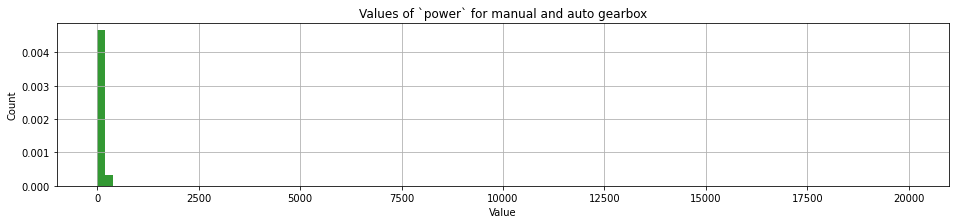

In [38]:
plt.figure(figsize=(16, 3))
data['power'].hist(color = "green", bins = 100, density=True, alpha = 0.8)
plt.title('Values of `power` for manual and auto gearbox')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [39]:
len(data.query('power > 500'))/len(data)

0.001348202596716271

We see, there are some outliers, let's drop the values above 500:

In [40]:
data = data.query('power < 500').reset_index()

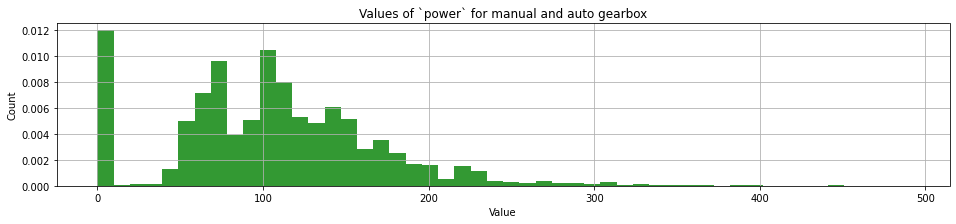

In [41]:
plt.figure(figsize=(16, 3))
data['power'].hist(color = "green", bins = 50, density=True, alpha = 0.8)
plt.title('Values of `power` for manual and auto gearbox')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

OK, now we see there are cars with zero power...

In [42]:
len(data.query('power == 0'))/len(data)

0.11626522327469553

... and there are 11% of these cars.

Let's replace these zeroes with NaNs and see how we can treat them later on:

In [43]:
data['power'] = data['power'].replace(0,np.NaN)   # replacement in numerical variables

In [44]:
# check the overall number of observations
data.shape

(332550, 17)

In [45]:
data.isna().sum()/len(data)

index                 0.000000
date_crawled          0.000000
price                 0.000000
vehicle_type          0.000000
registration_year     0.000000
gearbox               0.057083
power                 0.116265
model                 0.000000
mileage               0.000000
registration_month    0.000000
fuel_type             0.095619
brand                 0.000000
not_repaired          0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

Let's study vehicles by `fuel_type`:

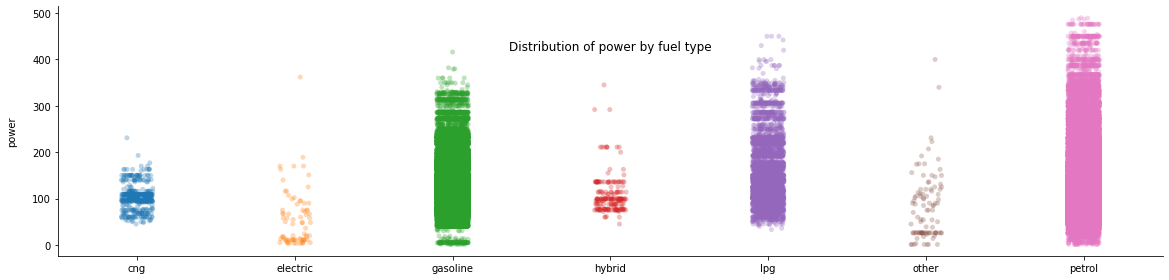

In [46]:
sns.catplot(x='fuel_type', y='power', data=data[data['power'] > 0], height=4, aspect=4, alpha = 0.3)
plt.xlabel("")
plt.ylabel("power", labelpad=15)
plt.title("Distribution of power by fuel type", y=0.8)
plt.show()

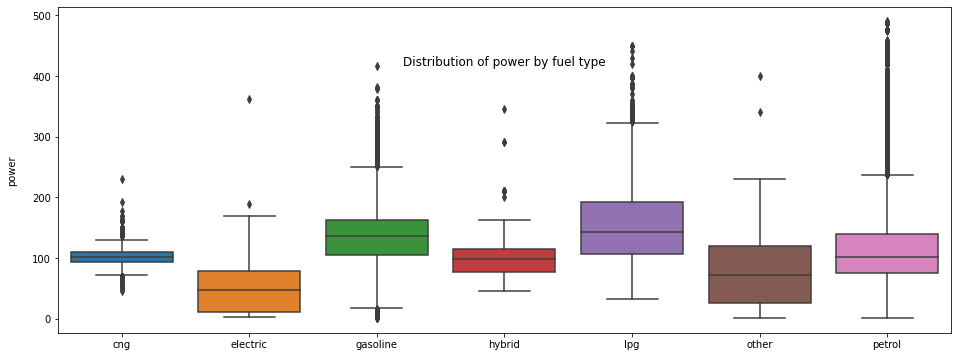

In [47]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='fuel_type', y='power', data=data[data['power'] > 0])
plt.xlabel("")
plt.ylabel("power", labelpad=15)
plt.title("Distribution of power by fuel type", y=0.8)
plt.show()

First, we see that among petrol cars the share of more powerfull cars is lower, although there are more outliers. In addition, we see that there are vehicles with `power` values less than 30, which is unreasonable for a car; we will add these values to missing ones to see how we can fill them later on.

In [48]:
data['power'] = np.where(data['power']<30, np.NaN, data['power'])

In [49]:
data.isna().sum()/len(data)

index                 0.000000
date_crawled          0.000000
price                 0.000000
vehicle_type          0.000000
registration_year     0.000000
gearbox               0.057083
power                 0.118887
model                 0.000000
mileage               0.000000
registration_month    0.000000
fuel_type             0.095619
brand                 0.000000
not_repaired          0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

Let's check the distribution of power by fuel type again:

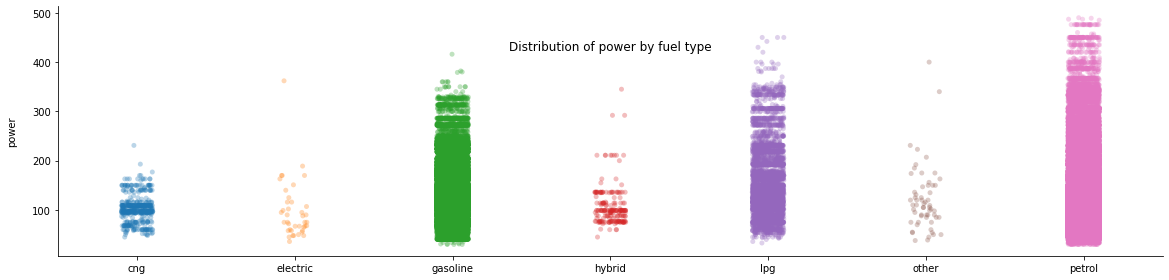

In [50]:
sns.catplot(x='fuel_type', y='power', data=data[data['power'] > 0], height=4, aspect=4, alpha = 0.3)
plt.xlabel("")
plt.ylabel("power", labelpad=15)
plt.title("Distribution of power by fuel type", y=0.8)
plt.show()

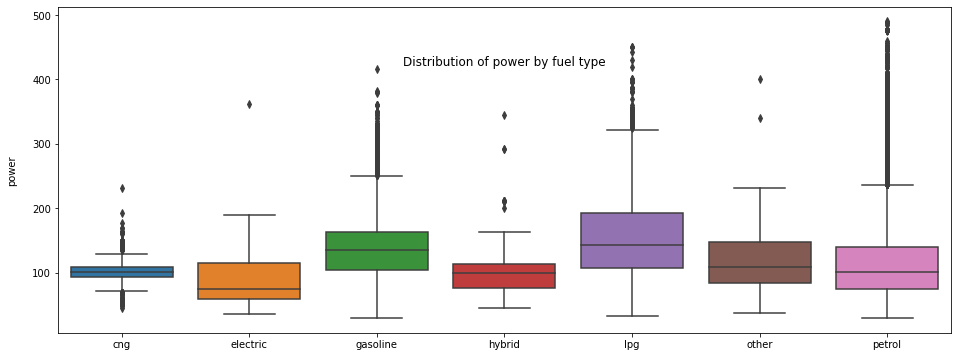

In [51]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='fuel_type', y='power', data=data[data['power'] > 0])
plt.xlabel("")
plt.ylabel("power", labelpad=15)
plt.title("Distribution of power by fuel type", y=0.8)
plt.show()

Now, let's study the vehicles by types:

In [52]:
data['vehicle_type'].value_counts(normalize = True)

sedan          0.257158
small          0.224838
wagon          0.182857
unknown        0.108438
bus            0.081272
convertible    0.056800
coupe          0.045798
suv            0.033312
other          0.009526
Name: vehicle_type, dtype: float64

In [53]:
vehicle_type_list = [name for name in list(data['vehicle_type'].unique()) if name not in ['other', 'unknown']]

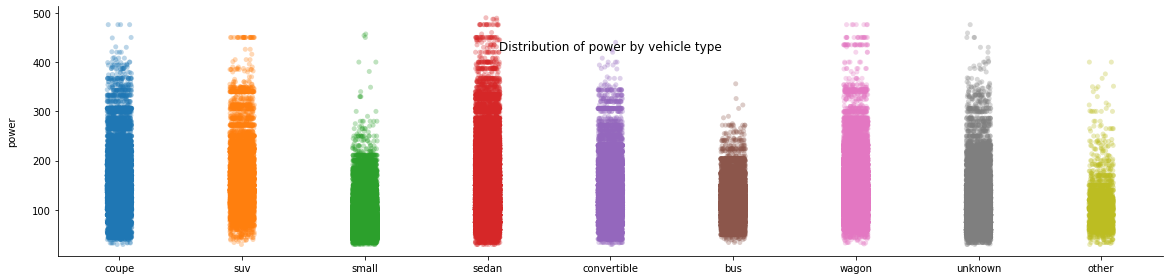

In [54]:
sns.catplot(x='vehicle_type', y='power', data=data[data['power'] > 0], height=4, aspect=4, alpha = 0.3)
plt.xlabel("")
plt.ylabel("power", labelpad=15)
plt.title("Distribution of power by vehicle type", y=0.8)
plt.show()

Small cars naturally have less powerfull engines; however, we also see that the category called `buses` has the same range of the `power` variable values as small cars...

OK, let's take a look at the distributions of the `power` variable by gear type:

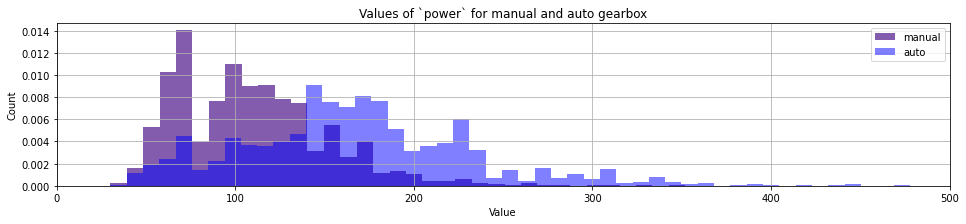

In [55]:
plt.figure(figsize=(16, 3))
data[(data['gearbox']=='manual') & (data['power']>0)]['power'].hist(color = "rebeccapurple",
                                                                    bins = 50, density=True, alpha = 0.8)
data[(data['gearbox']=='auto') & (data['power']>0)]['power'].hist(color = "blue", bins = 50, density = True, alpha = 0.5)
plt.title('Values of `power` for manual and auto gearbox')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend(['manual', 'auto'])
plt.xlim(0,500)
plt.show()

From the analysis before, it follows that it can be a reasonable idea to try to predict the missing variables, e.g. by using a `RandomForestClassifier` model for category variables and `RandomForesrRegressor` for numerical variables. For the predictions to be good enough, their scoring metrics should be above whatever any dummy model scores. Although, the underlying idea of the whole exercise is that any such model will work better, than simply plugging a mode/median/mean value, especially when there are more than 2 categories and the observations are more or less uniformely distributed by those categories.

To accomplish this task, we will:
- extract the dataset (variables) for modeling (from the initial dataset `data_raw`);
- extract a clean subset, without missing values, to use for modeling;
- choose a variable to fill in missing values and apply modeling:
    - extract the subset with missing values for the variable of interest;
    - create a model with that variable as a target to fill in the missing values;
    - use the model to predict missing values;
    - concatinate the observations with the predicted missing values with the clean subset and update the clean subset;
- choose the next variable to predict and repeat the modeling for it.

NOTE: there are observations for which two and more variables have missing values; in this case, filling the missing values will be iterative.

[Back to Content](#content)

#### Predicting missing values in car technical specification variables

1. Let us choose the variables to use for predicting the missing values:

In [56]:
missing_models_vars = ['vehicle_type', 'gearbox', 'fuel_type', 'power', 'brand', 'model']

In [57]:
missing_models_cat_vars = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'model']

In [58]:
data_to_model_missing = data_raw[missing_models_vars].copy()

In [59]:
# unclear `power` data -> missing
data_to_model_missing['power'] = np.where(data_to_model_missing['power']<30, np.nan, data_to_model_missing['power'])

The share of the observations before filling in any missing values:

In [60]:
data_to_model_missing.dropna().shape[0] / data_raw.shape[0]

0.7486247732977817

25% of the initial dataset contain missing values either in one or more variables.

In [61]:
data_to_model_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333036 entries, 0 to 333035
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  296896 non-null  category
 1   gearbox       314021 non-null  category
 2   fuel_type     301134 non-null  category
 3   power         293500 non-null  float64 
 4   brand         333036 non-null  category
 5   model         314013 non-null  category
dtypes: category(5), float64(1)
memory usage: 4.5 MB


In [62]:
data_to_model_missing_vars_order = list(data_to_model_missing.isna().sum().sort_values().index)

In [63]:
data_to_model_missing_vars_order

['brand', 'gearbox', 'model', 'fuel_type', 'vehicle_type', 'power']

In [64]:
# order the categorical variables list by ascending amount of missing values
missing_models_cat_vars_ordered = [x for x in data_to_model_missing_vars_order if x in missing_models_cat_vars]

This is the order, in which we will model the missing values, starting from `gearbox` (variable `brand` has no missing values).

In [65]:
missing_models_cat_vars_ordered

['brand', 'gearbox', 'model', 'fuel_type', 'vehicle_type']

**2.1 Extract a clean subset with the variables of interest:**

In [66]:
data_without_missing = data_to_model_missing.dropna()

In [67]:
data_without_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249319 entries, 2 to 333035
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  249319 non-null  category
 1   gearbox       249319 non-null  category
 2   fuel_type     249319 non-null  category
 3   power         249319 non-null  float64 
 4   brand         249319 non-null  category
 5   model         249319 non-null  category
dtypes: category(5), float64(1)
memory usage: 5.2 MB


**3.1 We will extract the subset with missing values for the first variable of interest, the one with the least amount of the missing values, `gearbox`:**

In [68]:
def missing_values_subset_by_var(df: pd.DataFrame, missing_var: str):
    """Returns a subset of `df` in which values for only one variable, `missing_var`, are missing."""
    list_of_vars = df.columns.to_list()
    dropna_vars = [name for name in list_of_vars if name != missing_var]
    return df[df[missing_var].isna()].dropna(subset=dropna_vars)

In [69]:
gearbox_missing = missing_values_subset_by_var(data_to_model_missing, 'gearbox')
gearbox_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181 entries, 208 to 332962
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vehicle_type  3181 non-null   category
 1   gearbox       0 non-null      category
 2   fuel_type     3181 non-null   category
 3   power         3181 non-null   float64 
 4   brand         3181 non-null   category
 5   model         3181 non-null   category
dtypes: category(5), float64(1)
memory usage: 80.6 KB


**4.1 Now, let's build a model with the `gearbox` variable as target (based on the source code [here](https://medium.com/analytics-vidhya/handle-missing-values-in-categorical-features-b7c5b073dda2)):**

First, we encode the categorical variables:

In [70]:
def encoding_dict(df,col_name):
    """Builds a map of categories to codes"""
    keys = list(df[col_name].unique())
    mapping = {}
    for tup in list(zip(keys, range(0,len(keys)))):
        mapping[tup[0]] = tup[1]
    return mapping

Example:

In [71]:
vehicle_type_dict = encoding_dict(data_without_missing, 'vehicle_type')

In [72]:
vehicle_type_dict

{'suv': 0,
 'small': 1,
 'sedan': 2,
 'convertible': 3,
 'bus': 4,
 'wagon': 5,
 'coupe': 6,
 'other': 7}

In [73]:
data_without_missing_encoded = data_without_missing.copy()
for col in missing_models_cat_vars:
    data_without_missing_encoded[col] = data_without_missing_encoded[col].map(encoding_dict(data_to_model_missing, col)) 

In [74]:
data_without_missing_encoded.head()

,vehicle_type,gearbox,fuel_type,power,brand,model
2,2,1,1,163.0,2,2
3,3,0,0,75.0,0,0
4,3,0,1,69.0,3,3
5,4,0,0,102.0,4,4
6,5,0,0,109.0,5,5


In [75]:
X = data_without_missing_encoded.drop('gearbox', axis=1).values
Y = data_without_missing_encoded['gearbox'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=54321)

forest = RandomForestClassifier(random_state = 54321)  # use the default model
forest.fit(X_train, Y_train)
y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))

importances = forest.feature_importances_
indices = list(np.argsort(importances))[::-1]

ACCURACY: TRAIN=0.8837 TEST=0.8666


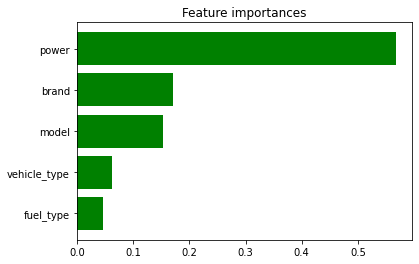

In [76]:
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="g", align="center")
plt.yticks(range(len(indices)), data_without_missing_encoded.drop('gearbox', axis=1).columns[indices])
plt.gca().invert_yaxis()

The most important features for the `gearbox` are engine power and the model/brand.

**5.1 Now that we have the model, let’s plug the values of the predictions back into the `data_to_model_missing` dataframe:**

In [77]:
for col in [col for col in missing_models_cat_vars if col != 'gearbox']:
    gearbox_missing[col] = gearbox_missing[col].map(encoding_dict(data_to_model_missing, col)) 

In [78]:
gearbox_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181 entries, 208 to 332962
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vehicle_type  3181 non-null   category
 1   gearbox       0 non-null      category
 2   fuel_type     3181 non-null   category
 3   power         3181 non-null   float64 
 4   brand         3181 non-null   category
 5   model         3181 non-null   category
dtypes: category(5), float64(1)
memory usage: 80.6 KB


In [79]:
prediction = forest.predict(gearbox_missing.drop('gearbox', axis=1))

In [80]:
indices_to_fill_predictions = gearbox_missing.index

In [81]:
data_to_model_missing_gearbox = data_to_model_missing.loc[indices_to_fill_predictions,:]

In [82]:
data_to_model_missing_gearbox['gearbox'] = prediction

In [83]:
data_to_model_missing_gearbox.head()

,vehicle_type,gearbox,fuel_type,power,brand,model
208,small,1,gasoline,41.0,smart,fortwo
276,convertible,0,petrol,115.0,volkswagen,golf
296,sedan,0,petrol,75.0,opel,astra
359,sedan,1,petrol,299.0,audi,a6
468,small,1,petrol,61.0,smart,fortwo


In [84]:
gearbox_dict = encoding_dict(data_to_model_missing, 'gearbox')
gearbox_dict

{'manual': 0, 'auto': 1, nan: 2}

In [85]:
def encoding_back_mapping(mapping):
    """Reverts the map of categories to codes and returns the revert mapping of codes to categories"""
    back_mapping = {}
    for key in mapping:
        back_mapping[mapping[key]] = key
    return back_mapping

In [86]:
# gearbox_dict_back = encoding_back_mapping(gearbox_dict)

In [87]:
gearbox_dict_back = encoding_back_mapping(encoding_dict(data_to_model_missing, 'gearbox'))

In [88]:
gearbox_dict_back

{0: 'manual', 1: 'auto', 2: nan}

In [89]:
data_to_model_missing_gearbox['gearbox'] = data_to_model_missing_gearbox['gearbox'].map(
    encoding_back_mapping(gearbox_dict)
)

In [90]:
data_to_model_missing_gearbox

,vehicle_type,gearbox,fuel_type,power,brand,model
208,small,auto,gasoline,41.0,smart,fortwo
276,convertible,manual,petrol,115.0,volkswagen,golf
296,sedan,manual,petrol,75.0,opel,astra
359,sedan,auto,petrol,299.0,audi,a6
468,small,auto,petrol,61.0,smart,fortwo
...,...,...,...,...,...,...
332319,bus,manual,gasoline,109.0,renault,kangoo
332324,wagon,manual,petrol,120.0,volkswagen,passat
332355,sedan,manual,petrol,139.0,volkswagen,golf
332833,small,manual,petrol,75.0,volkswagen,golf


**6.1 Updating the initial training/testing subset.**

Now we concatinate the restored observations to that part of the initial `data_to_model_missing` which did not have missing values in the `gearbox` variable, thus, update the `data_to_model_missing`, and make another iteration on the next variable with the least missing values.

In [91]:
indices_to_keep = [idx for idx in list(data_to_model_missing.index) if idx not in indices_to_fill_predictions]

In [92]:
df_to_concatenate = data_to_model_missing.filter(items = indices_to_keep, axis=0)

In [93]:
frames = [df_to_concatenate, data_to_model_missing_gearbox]
data_to_model_missing = pd.concat(frames)

In [94]:
data_to_model_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 332962
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  296896 non-null  category
 1   gearbox       317202 non-null  object  
 2   fuel_type     301134 non-null  category
 3   power         293500 non-null  float64 
 4   brand         333036 non-null  category
 5   model         314013 non-null  category
dtypes: category(4), float64(1), object(1)
memory usage: 9.2+ MB


Let's build a model for the next variable, `model`.

**2.2 Update the training/testing data**

In [95]:
data_without_missing = data_to_model_missing.dropna()

In [96]:
data_without_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252500 entries, 2 to 332962
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  252500 non-null  category
 1   gearbox       252500 non-null  object  
 2   fuel_type     252500 non-null  category
 3   power         252500 non-null  float64 
 4   brand         252500 non-null  category
 5   model         252500 non-null  category
dtypes: category(4), float64(1), object(1)
memory usage: 7.0+ MB


**3.2 Extract subset with missing values for the target variable**

In [97]:
model_missing = missing_values_subset_by_var(data_to_model_missing, 'model')
model_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7471 entries, 1 to 332994
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vehicle_type  7471 non-null   category
 1   gearbox       7471 non-null   object  
 2   fuel_type     7471 non-null   category
 3   power         7471 non-null   float64 
 4   brand         7471 non-null   category
 5   model         0 non-null      category
dtypes: category(4), float64(1), object(1)
memory usage: 223.7+ KB


**4.2 Modeling**

In [98]:
data_without_missing_encoded = data_without_missing.copy()
for col in missing_models_cat_vars:
    data_without_missing_encoded[col] = data_without_missing_encoded[col].map(encoding_dict(data_to_model_missing, col))

In [99]:
data_without_missing_encoded.head()

,vehicle_type,gearbox,fuel_type,power,brand,model
2,2,1,1,163.0,2,2
3,3,0,0,75.0,0,0
4,3,0,1,69.0,3,3
5,4,0,0,102.0,4,4
6,5,0,0,109.0,5,5


In [100]:
X = data_without_missing_encoded.drop('model', axis=1).values
Y = data_without_missing_encoded['model'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=54321)

forest = RandomForestClassifier(random_state = 54321)  # use the default model
forest.fit(X_train, Y_train)
y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))

importances = forest.feature_importances_
indices = list(np.argsort(importances))[::-1]

ACCURACY: TRAIN=0.7869 TEST=0.7589


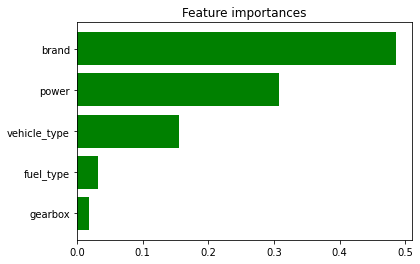

In [101]:
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="g", align="center")
plt.yticks(range(len(indices)), data_without_missing_encoded.drop('model', axis=1).columns[indices])
plt.gca().invert_yaxis()

As expected, model is highly correlated with the brand and engine power, while accuracy is lower, which can be explained by the large number of categories.

**5.2 Insert predicted values**

In [102]:
for col in [col for col in missing_models_cat_vars if col != 'model']:
    model_missing[col] = model_missing[col].map(encoding_dict(data_to_model_missing, col))

In [103]:
model_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7471 entries, 1 to 332994
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vehicle_type  7471 non-null   category
 1   gearbox       7471 non-null   int64   
 2   fuel_type     7471 non-null   category
 3   power         7471 non-null   float64 
 4   brand         7471 non-null   category
 5   model         0 non-null      category
dtypes: category(4), float64(1), int64(1)
memory usage: 223.7 KB


In [104]:
prediction = forest.predict(model_missing.drop('model', axis=1))

In [105]:
indices_to_fill_predictions = model_missing.index

In [106]:
data_to_model_missing_model = data_to_model_missing.loc[indices_to_fill_predictions,:]

In [107]:
data_to_model_missing_model['model'] = prediction

In [108]:
model_dict_back = encoding_back_mapping(encoding_dict(data_to_model_missing, 'model'))

In [109]:
data_to_model_missing_model['model'] = data_to_model_missing_model['model'].map(model_dict_back)

**6.2 Now we will update the `data_to_model_missing` dataset with the new, restored, observations.**

In [110]:
indices_to_keep = [idx for idx in list(data_to_model_missing.index) if idx not in indices_to_fill_predictions]

In [111]:
df_to_concatenate = data_to_model_missing.filter(items = indices_to_keep, axis=0)

In [112]:
frames = [df_to_concatenate, data_to_model_missing_model]
data_to_model_missing = pd.concat(frames)

In [113]:
data_to_model_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 332994
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  296896 non-null  category
 1   gearbox       317202 non-null  object  
 2   fuel_type     301134 non-null  category
 3   power         293500 non-null  float64 
 4   brand         333036 non-null  category
 5   model         321484 non-null  object  
dtypes: category(3), float64(1), object(2)
memory usage: 11.1+ MB


Let's build a model for the next variable, `fuel_type`. This time, we will refactor some variable names to design the whole procedure as a function.

**2.3 Update the training/testing data**

In [114]:
data_without_missing = data_to_model_missing.dropna()

In [115]:
data_without_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259971 entries, 2 to 332994
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  259971 non-null  category
 1   gearbox       259971 non-null  object  
 2   fuel_type     259971 non-null  category
 3   power         259971 non-null  float64 
 4   brand         259971 non-null  category
 5   model         259971 non-null  object  
dtypes: category(3), float64(1), object(2)
memory usage: 8.7+ MB


**3.3 Extract subset with missing values for the target variable**

In [116]:
target_missing = missing_values_subset_by_var(data_to_model_missing, 'fuel_type')
target_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8867 entries, 9 to 333009
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vehicle_type  8867 non-null   category
 1   gearbox       8867 non-null   object  
 2   fuel_type     0 non-null      category
 3   power         8867 non-null   float64 
 4   brand         8867 non-null   category
 5   model         8867 non-null   object  
dtypes: category(3), float64(1), object(2)
memory usage: 305.1+ KB


**4.3 Modeling**

In [117]:
data_without_missing_encoded = data_without_missing.copy()
for col in missing_models_cat_vars:
    data_without_missing_encoded[col] = data_without_missing_encoded[col].map(encoding_dict(data_to_model_missing, col))

In [118]:
data_without_missing_encoded.head()

,vehicle_type,gearbox,fuel_type,power,brand,model
2,1,1,1,163.0,1,1
3,2,0,0,75.0,0,0
4,2,0,1,69.0,2,2
5,3,0,0,102.0,3,3
6,4,0,0,109.0,4,4


In [119]:
X = data_without_missing_encoded.drop('fuel_type', axis=1).values
Y = data_without_missing_encoded['fuel_type'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=54321)

forest = RandomForestClassifier(random_state = 54321)  # use the default model
forest.fit(X_train, Y_train)
y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))

importances = forest.feature_importances_
indices = list(np.argsort(importances))[::-1]

ACCURACY: TRAIN=0.9068 TEST=0.8920


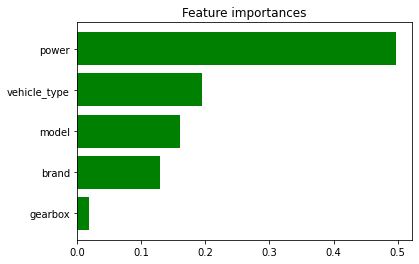

In [120]:
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="g", align="center")
plt.yticks(range(len(indices)), data_without_missing_encoded.drop('fuel_type', axis=1).columns[indices])
plt.gca().invert_yaxis()

As expected, model is highly correlated with the engine power and the type of vehicle; accuracy is relatively high.

**5.3 Insert predicted values**

In [121]:
for col in [col for col in missing_models_cat_vars if col != 'fuel_type']:
    target_missing[col] = target_missing[col].map(encoding_dict(data_to_model_missing, col))

In [122]:
target_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8867 entries, 9 to 333009
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vehicle_type  8867 non-null   category
 1   gearbox       8867 non-null   int64   
 2   fuel_type     0 non-null      category
 3   power         8867 non-null   float64 
 4   brand         8867 non-null   category
 5   model         8867 non-null   int64   
dtypes: category(3), float64(1), int64(2)
memory usage: 305.1 KB


In [123]:
prediction = forest.predict(target_missing.drop('fuel_type', axis=1))

In [124]:
indices_to_fill_predictions = target_missing.index

In [125]:
data_to_model_missing_target = data_to_model_missing.loc[indices_to_fill_predictions,:]

In [126]:
data_to_model_missing_target['fuel_type'] = prediction

In [127]:
target_back_mapping_dict = encoding_back_mapping(encoding_dict(data_to_model_missing, 'fuel_type'))

In [128]:
data_to_model_missing_target['fuel_type'] = data_to_model_missing_target['fuel_type'].map(target_back_mapping_dict)

**6.3 Now we will update the `data_to_model_missing` dataset with the new, restored, observations.**

In [129]:
indices_to_keep = [idx for idx in list(data_to_model_missing.index) if idx not in indices_to_fill_predictions]

In [130]:
df_to_concatenate = data_to_model_missing.filter(items = indices_to_keep, axis=0)

In [131]:
frames = [df_to_concatenate, data_to_model_missing_target]
data_to_model_missing = pd.concat(frames)

In [132]:
data_to_model_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 333009
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  296896 non-null  category
 1   gearbox       317202 non-null  object  
 2   fuel_type     310001 non-null  object  
 3   power         293500 non-null  float64 
 4   brand         333036 non-null  category
 5   model         321484 non-null  object  
dtypes: category(2), float64(1), object(3)
memory usage: 13.3+ MB


Let's proceed to `vehicle_type` variable, this time we will wrap up the procedure into a function:

In [133]:
def iterative_missing_values_modeling(modeling_dataset, model_cat_var_list, target_var_name):
    print(f'Started modeling for the `{target_var_name}` variable.')
    
    # step 1, choosing the dataset for modeling, is performed outside the function
    # step 2 - extract a dataset with no missing values accros all the variables
    print('\nClean data subset:')
    no_missing_df = modeling_dataset.dropna()
    print(no_missing_df.info())
    
    # step 3 - extract the data subset with missing values for the target variable
    print('\nMissing target variable subset:')
    missing_target_df = missing_values_subset_by_var(modeling_dataset, target_var_name)
    print(missing_target_df.info())
    
    # step 4 - build a model for the target category variable
    no_missing_encoded_df = no_missing_df.copy()
    for col in model_cat_var_list:
        no_missing_encoded_df[col] = no_missing_encoded_df[col].map(encoding_dict(modeling_dataset, col))
    # print('\n', data_without_missing_encoded.head())
    
    X = no_missing_encoded_df.drop(target_var_name, axis=1).values
    Y = no_missing_encoded_df[target_var_name].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=54321)
    forest = RandomForestClassifier(random_state = 54321)  # use the default model
    forest.fit(X_train, Y_train)
    y_pred_train = forest.predict(X_train)
    y_pred = forest.predict(X_test)
    accuracy_train = accuracy_score(Y_train, y_pred_train)
    accuracy_test = accuracy_score(Y_test, y_pred)
    print(f"\nAccuracy of {target_var_name} model: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
    importances = forest.feature_importances_
    indices = list(np.argsort(importances))[::-1]
    
    plt.title("Feature importances")
    plt.barh(range(len(indices)), importances[indices], color="g", align="center")
    plt.yticks(range(len(indices)), no_missing_encoded_df.drop(target_var_name, axis=1).columns[indices])
    plt.gca().invert_yaxis()
    plt.show()

    # step 5 - insert predicted values of the target variable
    for col in [col for col in model_cat_var_list if col != target_var_name]:
        missing_target_df[col] = missing_target_df[col].map(encoding_dict(modeling_dataset, col))
    # print('\n', missing_target_df.info())
    
    prediction = forest.predict(missing_target_df.drop(target_var_name, axis=1))
    indices_to_fill_predictions = missing_target_df.index
    modeling_dataset_target = modeling_dataset.loc[indices_to_fill_predictions,:]
    modeling_dataset_target[target_var_name] = prediction
    target_back_mapping_dict = encoding_back_mapping(encoding_dict(modeling_dataset, target_var_name))
    modeling_dataset_target[target_var_name] = modeling_dataset_target[target_var_name].map(target_back_mapping_dict)
    
    # step 6 - update the initial dataset for modeling
    indices_to_keep = [idx for idx in list(modeling_dataset.index) if idx not in indices_to_fill_predictions]
    df_to_concatenate = modeling_dataset.filter(items = indices_to_keep, axis=0)
    frames = [df_to_concatenate, modeling_dataset_target]
    modeling_dataset = pd.concat(frames)
    print('\nUpdated modeling subset:')
    print(modeling_dataset.info())
    print(f'\nFinished modeling for the `{target_var_name}` variable.')
    
    return modeling_dataset

Started modeling for the `vehicle_type` variable.

Clean data subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 268838 entries, 2 to 333009
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  268838 non-null  category
 1   gearbox       268838 non-null  object  
 2   fuel_type     268838 non-null  object  
 3   power         268838 non-null  float64 
 4   brand         268838 non-null  category
 5   model         268838 non-null  object  
dtypes: category(2), float64(1), object(3)
memory usage: 10.8+ MB
None

Missing target variable subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10420 entries, 22 to 332866
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vehicle_type  0 non-null      category
 1   gearbox       10420 non-null  object  
 2   fuel_type     10420 non-null  object  
 3   power         10420 n

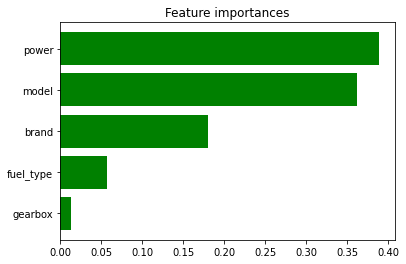


Updated modeling subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 332866
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  307316 non-null  object  
 1   gearbox       317202 non-null  object  
 2   fuel_type     310001 non-null  object  
 3   power         293500 non-null  float64 
 4   brand         333036 non-null  category
 5   model         321484 non-null  object  
dtypes: category(1), float64(1), object(4)
memory usage: 15.6+ MB
None

Finished modeling for the `vehicle_type` variable.


In [134]:
data_to_model_missing = iterative_missing_values_modeling(data_to_model_missing, missing_models_cat_vars, 'vehicle_type')

In [135]:
data_to_model_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 332866
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  307316 non-null  object  
 1   gearbox       317202 non-null  object  
 2   fuel_type     310001 non-null  object  
 3   power         293500 non-null  float64 
 4   brand         333036 non-null  category
 5   model         321484 non-null  object  
dtypes: category(1), float64(1), object(4)
memory usage: 15.6+ MB


Now, we can make additional check and run the automated version of the developed procedure for all the category variables, starting from the very beginning:

Started modeling for the `gearbox` variable.

Clean data subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 249319 entries, 2 to 333035
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  249319 non-null  category
 1   gearbox       249319 non-null  category
 2   fuel_type     249319 non-null  category
 3   power         249319 non-null  float64 
 4   brand         249319 non-null  category
 5   model         249319 non-null  category
dtypes: category(5), float64(1)
memory usage: 5.2 MB
None

Missing target variable subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181 entries, 208 to 332962
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vehicle_type  3181 non-null   category
 1   gearbox       0 non-null      category
 2   fuel_type     3181 non-null   category
 3   power         3181 non-null   float64 


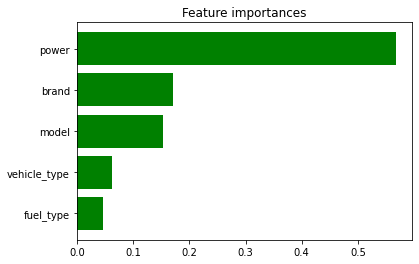


Updated modeling subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 332962
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  296896 non-null  category
 1   gearbox       317202 non-null  object  
 2   fuel_type     301134 non-null  category
 3   power         293500 non-null  float64 
 4   brand         333036 non-null  category
 5   model         314013 non-null  category
dtypes: category(4), float64(1), object(1)
memory usage: 9.2+ MB
None

Finished modeling for the `gearbox` variable.
Started modeling for the `model` variable.

Clean data subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 252500 entries, 2 to 332962
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  252500 non-null  category
 1   gearbox       252500 non-null  object  
 2   fuel_type     252500 non-null

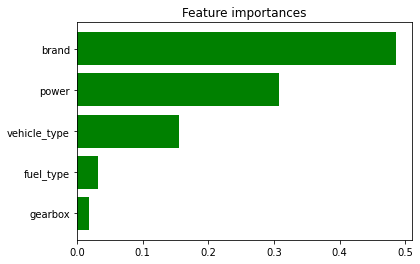


Updated modeling subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 332994
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  296896 non-null  category
 1   gearbox       317202 non-null  object  
 2   fuel_type     301134 non-null  category
 3   power         293500 non-null  float64 
 4   brand         333036 non-null  category
 5   model         321484 non-null  object  
dtypes: category(3), float64(1), object(2)
memory usage: 11.1+ MB
None

Finished modeling for the `model` variable.
Started modeling for the `fuel_type` variable.

Clean data subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 259971 entries, 2 to 332994
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  259971 non-null  category
 1   gearbox       259971 non-null  object  
 2   fuel_type     259971 non-n

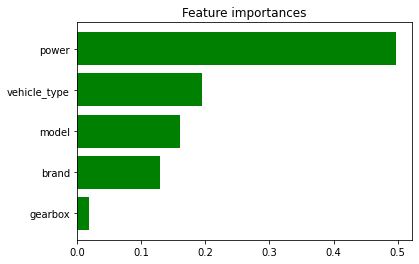


Updated modeling subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 333009
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  296896 non-null  category
 1   gearbox       317202 non-null  object  
 2   fuel_type     310001 non-null  object  
 3   power         293500 non-null  float64 
 4   brand         333036 non-null  category
 5   model         321484 non-null  object  
dtypes: category(2), float64(1), object(3)
memory usage: 13.3+ MB
None

Finished modeling for the `fuel_type` variable.
Started modeling for the `vehicle_type` variable.

Clean data subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 268838 entries, 2 to 333009
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  268838 non-null  category
 1   gearbox       268838 non-null  object  
 2   fuel_type     26883

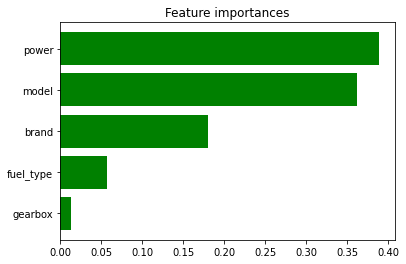


Updated modeling subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 332866
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  307316 non-null  object  
 1   gearbox       317202 non-null  object  
 2   fuel_type     310001 non-null  object  
 3   power         293500 non-null  float64 
 4   brand         333036 non-null  category
 5   model         321484 non-null  object  
dtypes: category(1), float64(1), object(4)
memory usage: 15.6+ MB
None

Finished modeling for the `vehicle_type` variable.


In [136]:
# extracting the dataset for modeling
data_to_model_missing = data_raw[missing_models_vars].copy()
# unclear `power` data -> missing
data_to_model_missing['power'] = np.where(data_to_model_missing['power']<30, np.nan, data_to_model_missing['power'])

for cat_var in missing_models_cat_vars_ordered[1:]:
    data_to_model_missing = iterative_missing_values_modeling(data_to_model_missing,
                                                              missing_models_cat_vars_ordered,
                                                              cat_var)

We succesfully finished the automated run with the same result!

Now, we have left with the `power` variable untreated. This variable is numeric; thus, we should use a regression model. Let's modify our script to include the option to make a switch to a regression model. To this end, we introduce `numerical_target` flag which defaults to `False` and correct the flow of calculations where relevant. Additionally, the final version of the script will include a check for emty dataset for constructing predictions for chosen target variable.

In [137]:
def iterative_missing_values_modeling(modeling_dataset, model_cat_var_list, target_var_name, numerical_target = False):
    print(f'Started modeling for the `{target_var_name}` variable.')
    
    # step 1, choosing the dataset for modeling, is performed outside the function
    # step 2 - extract a dataset with no missing values accros all the variables
    print('\nClean data subset:')
    no_missing_df = modeling_dataset.dropna()
    print(no_missing_df.info())
    
    # step 3 - extract the data subset with missing values for the target variable
    print('\nMissing target variable subset:')
    missing_target_df = missing_values_subset_by_var(modeling_dataset, target_var_name)
    print(missing_target_df.info())
    
    if len(missing_target_df) == 0:
        print("No subset for constructing predictions, observations with multiple missing values.")
    
    else:
    
        # step 4 - build a model for the target category variable
        no_missing_encoded_df = no_missing_df.copy()
        for col in model_cat_var_list:
            no_missing_encoded_df[col] = no_missing_encoded_df[col].map(encoding_dict(modeling_dataset, col))
        # print('\n', data_without_missing_encoded.head())

        X = no_missing_encoded_df.drop(target_var_name, axis=1).values
        Y = no_missing_encoded_df[target_var_name].values
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=54321)

        if numerical_target:
            forest = RandomForestRegressor(random_state = 54321)  # use the default model for demonstration purposes
            forest.fit(X_train, Y_train)
            y_pred_train = forest.predict(X_train)
            y_pred = forest.predict(X_test)

            mse_median = mean_squared_error(Y_test, 115*np.ones(len(y_pred)))
            mse_train = mean_squared_error(Y_train, y_pred_train)
            mse_test = mean_squared_error(Y_test, y_pred)
            rmse_test = mse_test**.5
            rmse_median = mse_median**.5

            print("MSE: TRAIN=%.4f TEST=%.4f MEDIAN=%.4f" % (mse_train,mse_test,mse_median))
            print("RMSE: TEST=%.4f" % rmse_test)

        else:
            forest = RandomForestClassifier(random_state = 54321)  # use the default model for demonstration purposes
            forest.fit(X_train, Y_train)
            y_pred_train = forest.predict(X_train)
            y_pred = forest.predict(X_test)
            accuracy_train = accuracy_score(Y_train, y_pred_train)
            accuracy_test = accuracy_score(Y_test, y_pred)
            print(f"\nAccuracy of {target_var_name} model: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))

        importances = forest.feature_importances_
        indices = list(np.argsort(importances))[::-1]

        plt.title("Feature importances")
        plt.barh(range(len(indices)), importances[indices], color="g", align="center")
        plt.yticks(range(len(indices)), no_missing_encoded_df.drop(target_var_name, axis=1).columns[indices])
        plt.gca().invert_yaxis()
        plt.show()

        # step 5 - insert predicted values of the target variable
        for col in [col for col in model_cat_var_list if col != target_var_name]:
            missing_target_df[col] = missing_target_df[col].map(encoding_dict(modeling_dataset, col))
        # print('\n', missing_target_df.info())

        prediction = forest.predict(missing_target_df.drop(target_var_name, axis=1))

        indices_to_fill_predictions = missing_target_df.index
        modeling_dataset_target = modeling_dataset.loc[indices_to_fill_predictions,:]
        modeling_dataset_target[target_var_name] = prediction

        # preserve the initial data representation
        if numerical_target:
            # rounding numerical values to the lower ten
            modeling_dataset_target[target_var_name] = 10*(modeling_dataset_target[target_var_name]//10)
            modeling_dataset_target[target_var_name] = modeling_dataset_target[target_var_name].astype('int')
        else:
            target_back_mapping_dict = encoding_back_mapping(encoding_dict(modeling_dataset, target_var_name))
            modeling_dataset_target[target_var_name] = modeling_dataset_target[target_var_name].map(
                target_back_mapping_dict)

        # step 6 - update the initial dataset for modeling
        indices_to_keep = [idx for idx in list(modeling_dataset.index) if idx not in indices_to_fill_predictions]
        df_to_concatenate = modeling_dataset.filter(items = indices_to_keep, axis=0)
        frames = [df_to_concatenate, modeling_dataset_target]
        modeling_dataset = pd.concat(frames)
        for cat_var in model_cat_var_list:
            modeling_dataset[cat_var] = modeling_dataset[cat_var].astype('category')
        print('\nUpdated modeling subset:')
        print(modeling_dataset.info())
    print(f'\nFinished modeling for the `{target_var_name}` variable.')
    
    return modeling_dataset

Let's give it a try:

In [138]:
data_to_model_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 332866
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  307316 non-null  object  
 1   gearbox       317202 non-null  object  
 2   fuel_type     310001 non-null  object  
 3   power         293500 non-null  float64 
 4   brand         333036 non-null  category
 5   model         321484 non-null  object  
dtypes: category(1), float64(1), object(4)
memory usage: 15.6+ MB


In [139]:
data_to_model_missing.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279258 entries, 2 to 332866
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  279258 non-null  object  
 1   gearbox       279258 non-null  object  
 2   fuel_type     279258 non-null  object  
 3   power         279258 non-null  float64 
 4   brand         279258 non-null  category
 5   model         279258 non-null  object  
dtypes: category(1), float64(1), object(4)
memory usage: 13.1+ MB


Started modeling for the `power` variable.

Clean data subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 279258 entries, 2 to 332866
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  279258 non-null  object  
 1   gearbox       279258 non-null  object  
 2   fuel_type     279258 non-null  object  
 3   power         279258 non-null  float64 
 4   brand         279258 non-null  category
 5   model         279258 non-null  object  
dtypes: category(1), float64(1), object(4)
memory usage: 13.1+ MB
None

Missing target variable subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15937 entries, 55 to 333028
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vehicle_type  15937 non-null  object  
 1   gearbox       15937 non-null  object  
 2   fuel_type     15937 non-null  object  
 3   power         0 non-null    

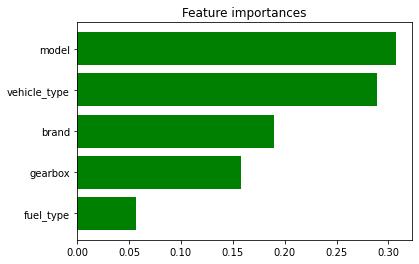


Updated modeling subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 333028
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  307316 non-null  category
 1   gearbox       317202 non-null  category
 2   fuel_type     310001 non-null  category
 3   power         309437 non-null  float64 
 4   brand         333036 non-null  category
 5   model         321484 non-null  category
dtypes: category(5), float64(1)
memory usage: 7.0 MB
None

Finished modeling for the `power` variable.


In [140]:
data_to_model_missing = iterative_missing_values_modeling(data_to_model_missing, missing_models_cat_vars,
                                                          'power', numerical_target = True)

For the engine power the `model` and the `vehicle_type` are the most correlated parameters.

At the moment, the share of valid observations after filling in missing values:

In [141]:
data_to_model_missing.dropna().shape[0] / data_raw.shape[0]

0.8863756470771929

After performing one iteration over the variables with missing values, only about 11.5% of the available observations still contain missing values.

Let's try and see whether another iteration will work as well.

In [142]:
for cat_var in missing_models_cat_vars_ordered[1:]:
    data_to_model_missing = iterative_missing_values_modeling(data_to_model_missing,
                                                              missing_models_cat_vars_ordered,
                                                              cat_var)

Started modeling for the `gearbox` variable.

Clean data subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 295195 entries, 2 to 333028
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  295195 non-null  category
 1   gearbox       295195 non-null  category
 2   fuel_type     295195 non-null  category
 3   power         295195 non-null  float64 
 4   brand         295195 non-null  category
 5   model         295195 non-null  category
dtypes: category(5), float64(1)
memory usage: 6.2 MB
None

Missing target variable subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vehicle_type  0 non-null      category
 1   gearbox       0 non-null      category
 2   fuel_type     0 non-null      category
 3   power         0 non-null      float64 
 4   brand        

In [143]:
data_to_model_missing = iterative_missing_values_modeling(data_to_model_missing, missing_models_cat_vars,
                                                          'power', numerical_target = True)

Started modeling for the `power` variable.

Clean data subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 295195 entries, 2 to 333028
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   vehicle_type  295195 non-null  category
 1   gearbox       295195 non-null  category
 2   fuel_type     295195 non-null  category
 3   power         295195 non-null  float64 
 4   brand         295195 non-null  category
 5   model         295195 non-null  category
dtypes: category(5), float64(1)
memory usage: 6.2 MB
None

Missing target variable subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   vehicle_type  0 non-null      category
 1   gearbox       0 non-null      category
 2   fuel_type     0 non-null      category
 3   power         0 non-null      float64 
 4   brand         0

OK, we cannot improve the result and will drop the rest of the observations with missing values:

In [144]:
data_to_model_missing.dropna(inplace = True)

We also need to sort the final version of the `data_to_model_missing` by index to correctly substitute the columns in the initial `data_raw` dataframe with its columns.

In [145]:
data_to_model_missing.sort_index(inplace = True)

In [146]:
data_to_model_missing.head()

,vehicle_type,gearbox,fuel_type,power,brand,model
1,coupe,manual,gasoline,190.0,audi,a5
2,suv,auto,gasoline,163.0,jeep,grand
3,small,manual,petrol,75.0,volkswagen,golf
4,small,manual,gasoline,69.0,skoda,fabia
5,sedan,manual,petrol,102.0,bmw,3er


Now, let's plug the resulting series into the initial dataset `data_raw`:

In [147]:
data_raw.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:00,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-07-04 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-07-04 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-05-04 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-06-04 10:17:00


In [148]:
df_to_update = data_raw.filter(items = data_to_model_missing.index, axis=0)

To make sure, let's sort this dataframe by the index as well:

In [149]:
df_to_update.sort_index(inplace = True)

Now we can just substitute the columns:

In [150]:
for col in data_to_model_missing.columns:
    df_to_update[col] = data_to_model_missing[col]

In [151]:
df_to_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295195 entries, 1 to 333035
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        295195 non-null  datetime64[ns]
 1   price               295195 non-null  int64         
 2   vehicle_type        295195 non-null  category      
 3   registration_year   295195 non-null  int64         
 4   gearbox             295195 non-null  category      
 5   power               295195 non-null  float64       
 6   model               295195 non-null  category      
 7   mileage             295195 non-null  int64         
 8   registration_month  295195 non-null  int64         
 9   fuel_type           295195 non-null  category      
 10  brand               295195 non-null  category      
 11  not_repaired        247836 non-null  category      
 12  date_created        295195 non-null  datetime64[ns]
 13  number_of_pictures  295195 no

[Back to Content](#content)

#### Predicting missing values in car state variables

Great, the only variable left untreated is `not_repaired`; it does not depend on the manufacturing characteristics of the cars, so we excluded it from the modeling above. Nevertheless, we can use the same script to model this variable. We will assume that `not_repaired` correlates with the `registration_year` and `mileage` variables:

Before we proceed, let's take a look at the distributions of the `registration_year` and `mileage` variables by `not_repaired`:

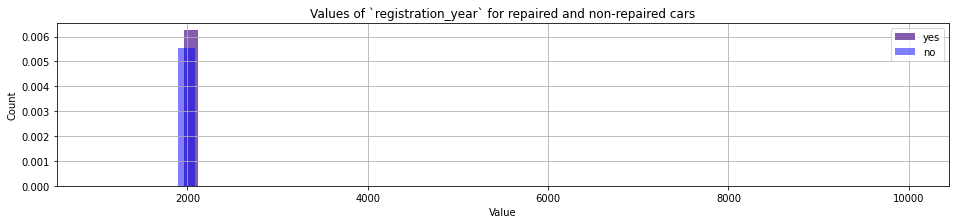

In [152]:
plt.figure(figsize=(16, 3))
data_raw[data_raw['not_repaired']=='yes']['registration_year'].hist(color = "rebeccapurple",
                                                                    bins = 50, density=True, alpha = 0.8)
data_raw[data_raw['not_repaired']=='no']['registration_year'].hist(color = "blue", bins = 50, density = True, alpha = 0.5)
plt.title('Values of `registration_year` for repaired and non-repaired cars')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend(['yes', 'no'])
#plt.xlim(0,500)
plt.show()

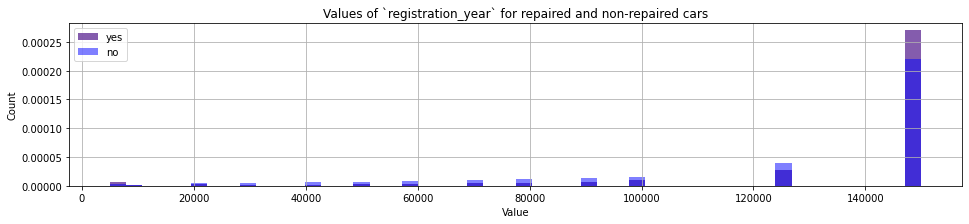

In [153]:
plt.figure(figsize=(16, 3))
data_raw[data_raw['not_repaired']=='yes']['mileage'].hist(color = "rebeccapurple",
                                                                    bins = 50, density=True, alpha = 0.8)
data_raw[data_raw['not_repaired']=='no']['mileage'].hist(color = "blue", bins = 50, density = True, alpha = 0.5)
plt.title('Values of `registration_year` for repaired and non-repaired cars')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend(['yes', 'no'])
#plt.xlim(0,500)
plt.show()

We definetely have a outliers in the `registration_year` variable; the `mileage` variable looks reasonable from the value range point of view, though the distribution looks a bit too discrete. Let's check how many outliers there are in the `registration_year` variable:

In [154]:
len(data_raw.query('(registration_year < 1900) | (registration_year > 2020)'))

164

~160 only, so we will drop them from the `df_to_update` before moving on:

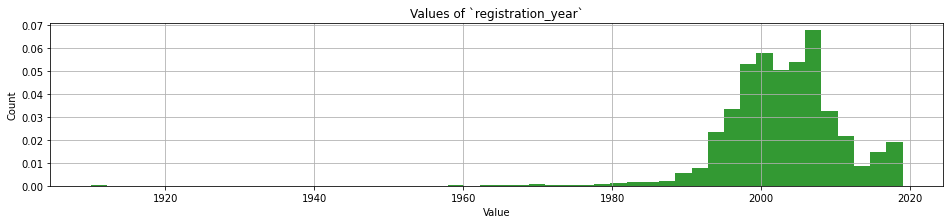

In [155]:
plt.figure(figsize=(16, 3))
data_raw.query('(registration_year < 2022) & (registration_year > 1900)')['registration_year'].hist(
    color = "green", bins = 50, density=True, alpha = 0.8)
plt.title('Values of `registration_year`')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [156]:
data_raw = data_raw.query('(registration_year >= 1900) & (registration_year < 2020)')

1. Now we can choose the variables to use for predicting the missing values. Actually it looks like car age should be a better proxy to the car state, so let's create the `car_age` variable:

Calculate car age:

In [157]:
data_raw['year_created'] = data_raw['date_created'].dt.year

In [158]:
data_raw['car_age'] = data_raw['year_created'] - data_raw['registration_year']

Thus, we can use `car_age` instead `registration_year` formodeling the `not_repaired` variable.

In [159]:
missing_not_repaired_vars = ['car_age', 'mileage', 'not_repaired']
missing_not_repaired_cat_vars = ['not_repaired']

Now we can extract the modeling subset:

In [160]:
data_to_model_not_repaired_missing = data_raw[missing_not_repaired_vars].copy()

2. Now we can simply apply the `iterative_missing_values_modeling` function.

Started modeling for the `not_repaired` variable.

Clean data subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 264952 entries, 1 to 333034
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   car_age       264952 non-null  int64   
 1   mileage       264952 non-null  int64   
 2   not_repaired  264952 non-null  category
dtypes: category(1), int64(2)
memory usage: 6.3 MB
None

Missing target variable subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 67920 entries, 0 to 333035
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   car_age       67920 non-null  int64   
 1   mileage       67920 non-null  int64   
 2   not_repaired  0 non-null      category
dtypes: category(1), int64(2)
memory usage: 1.6 MB
None

Accuracy of not_repaired model: TRAIN=0.8698 TEST=0.8675


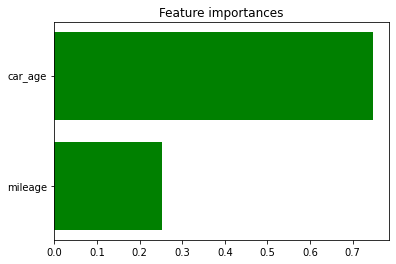


Updated modeling subset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 332872 entries, 1 to 333035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   car_age       332872 non-null  int64   
 1   mileage       332872 non-null  int64   
 2   not_repaired  332872 non-null  category
dtypes: category(1), int64(2)
memory usage: 7.9 MB
None

Finished modeling for the `not_repaired` variable.


In [161]:
data_to_model_not_repaired_missing = iterative_missing_values_modeling(data_to_model_not_repaired_missing,
                                                                       missing_not_repaired_cat_vars,
                                                                       'not_repaired')

As expected, the `car_age` exhibits the most impact on the `not_repaired` variable, which sounds reasonable; the accuracy of the model is pretty high.

Thus, we have missing values for `not_repaired` restored as well, let's plug them into the `df_to_update` dataframe.

In [162]:
data_to_model_not_repaired_missing.head()

,car_age,mileage,not_repaired
1,5,125000,yes
3,15,150000,no
4,8,90000,no
5,21,150000,yes
6,12,150000,no


We remember that `df_to_update` contains only part of the `data_to_model_not_repaired_missing` indices and it also should be cleaned from unreasonable values of `registration_year`:

In [163]:
not_repaired_restored_data = data_to_model_not_repaired_missing.filter(items = df_to_update.index, axis=0)

In [164]:
df_to_update.sort_index(inplace = True)
not_repaired_restored_data.sort_index(inplace = True)

In [165]:
df_to_update['not_repaired'] = not_repaired_restored_data['not_repaired']

In [166]:
df_to_update = df_to_update.query('(registration_year >= 1900) & (registration_year < 2020)')

In [167]:
df_to_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295187 entries, 1 to 333035
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        295187 non-null  datetime64[ns]
 1   price               295187 non-null  int64         
 2   vehicle_type        295187 non-null  category      
 3   registration_year   295187 non-null  int64         
 4   gearbox             295187 non-null  category      
 5   power               295187 non-null  float64       
 6   model               295187 non-null  category      
 7   mileage             295187 non-null  int64         
 8   registration_month  295187 non-null  int64         
 9   fuel_type           295187 non-null  category      
 10  brand               295187 non-null  category      
 11  not_repaired        295187 non-null  category      
 12  date_created        295187 non-null  datetime64[ns]
 13  number_of_pictures  295187 no

Now we are done with the missing variables. Let's finalize the data preprocessing.

[Back to Content](#content)

### Preprocessing wrap up

To finalize the preprocessing, we have two additional steps:
- study the `price` variable;
- drop irrelevant variables.

Let's take a look at the `price` variable:

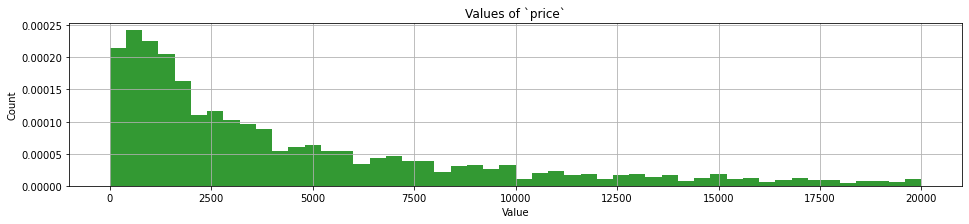

In [168]:
plt.figure(figsize=(16, 3))
data_raw['price'].hist(color = "green", bins = 50, density=True, alpha = 0.8)
plt.title('Values of `price`')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

Let's see how the scatter plot of `car_age` VS. `price` looks like:

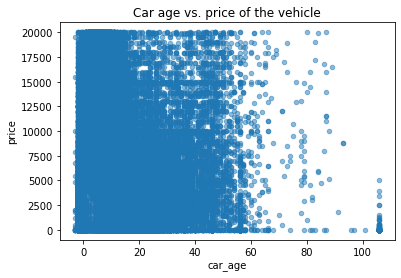

In [169]:
data_raw.plot.scatter(x='car_age', y='price', alpha=.5)
plt.title('Car age vs. price of the vehicle');

The distribution of the `price` variable looks very reasonable.

Now, we can finalize our clean dataset by dropping unnecessary variables:

In [170]:
df_to_update['car_age'] = df_to_update['date_created'].dt.year - df_to_update['registration_year']

In [171]:
df_to_update.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen', 'car_age'],
      dtype='object')

We have the `car_age` instead registration dates and listing creation data, we are less interested in number of pictures and the time the listing was seen for the last time:

In [172]:
data_not_encoded = df_to_update.drop(['date_crawled', 'registration_year', 'registration_month',
                          'date_created', 'number_of_pictures', 'last_seen'], axis=1)

Final remark: to be coherent with the meaning of the `postal_code` variable, we can explicitely define it as a category one as well.

In [173]:
data_not_encoded['postal_code'] = data_not_encoded['postal_code'].astype('category')

Our final dataset consist of ten variables:

In [174]:
data_not_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295187 entries, 1 to 333035
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         295187 non-null  int64   
 1   vehicle_type  295187 non-null  category
 2   gearbox       295187 non-null  category
 3   power         295187 non-null  float64 
 4   model         295187 non-null  category
 5   mileage       295187 non-null  int64   
 6   fuel_type     295187 non-null  category
 7   brand         295187 non-null  category
 8   not_repaired  295187 non-null  category
 9   postal_code   295187 non-null  category
 10  car_age       295187 non-null  int64   
dtypes: category(7), float64(1), int64(3)
memory usage: 14.1 MB


#### Data upload and preprocessing - summary

1. As part of the uploading process we checked memory usage and date types for a small subsample, which allowed us to avoid significant excessive use of the memory.
2. The raw dataset included ~K355 observations.
3. We found ~260 fully duplicated entries and K21+ implicite duplicates, which essentially looked like the same cars (including miliage, the postal code of the car and the price) crawled and published twice or more, so the listing would have different last time seen. To avoid any biases, we dropped those entries.
4. We performed extensive work on filling missing values:
- some variables were lacking between 5% to 20% of values;
- one variable, `power` had significant amount of unexpectedly low values, including zeros and values below 30 HP; in both cases we treated those values as missing.
5. During the missing variables pre-processing, we explored part of the variables and suggested using `RandomForestClassifier` to predict the missing values for categorical variables, like `fuel_type`, `gearbox`, and `vehicle_type`, and `RandomForestRegressor` to predict reasonable values instead zeros and near-zero values for the `power` variable.
6. To accomplish the task of filling in missing values, we developed the following procedure:
- extract the dataset (variables) for modeling (from the initial dataset `data_raw`);
- extract a clean subset, without missing values, to use for modeling;
- choose a variable to fill in missing values and apply modeling:
    - extract the subset with missing values for the variable of interest;
    - create a model with that variable as a target to fill in the missing values;
    - use the model to predict missing values;
    - concatinate the observations with the predicted missing values with the initial version of the clean subset and, thus, update it;
- choose the next variable to predict and repeat the modeling for it.
7. While implementing the procedre above, we automated most of its parts and ended up with one line function, `iterative_missing_values_modeling` applicable both for categorical and for numerical variables, for different subsets of related variables.
8. Thus, we restored missing variables in `fuel_type`, `model`, `gearbox`, `vehicle_type`, and `power` variables (the model considered only car manufacturing characteristics and included the `brand` variable as well), and then in `not_repaired` variable (we modeled it through `car_age` and `mileage`) and preserved ~14% of the dataset as it appeared after dropping duplicates.
9. Finally, we dropped irrelevantvariables, and ended up with a clean dataset of 10 variables with ~K295 observations.

[Back to Content](#content)

## Modeling the car value

In this part, we will implement the following:
1. Encode categorical variables data
2. Split the data
3. Define the score
4. Make a sanity check with a pipeline with Linear Regression
5. Build a tree-based algorithm with hyperparameter tuning (random forest)
6. Apply XGBoost with hyperparameter tuning
7. Apply LightGBM with hyperparameter tuning

### Encoding

In what follows, we will consider several models, `RandomForest`, `XGBoost`, and `LightGBM`. The latter has additional support for categorical features (see [here](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html), `CatBoost` [as well](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)). Since our categorical features are nominal (nor ordinal), using `LabelEncoder()` encoder seems to be a better solution.

In [175]:
labelencoder = LabelEncoder()

In [176]:
cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired', 'postal_code']

In [177]:
data = data_not_encoded.copy()

In [178]:
for col in cat_columns:
    data[col] = labelencoder.fit_transform(data[col])

In [179]:
data.head()

,price,vehicle_type,gearbox,power,model,mileage,fuel_type,brand,not_repaired,postal_code,car_age
1,18300,2,1,190.0,30,125000,2,1,1,4600,5
2,9800,6,0,163.0,117,125000,2,14,0,6973,12
3,1500,5,1,75.0,116,150000,6,38,0,7013,15
4,3600,5,1,69.0,101,90000,2,31,0,4197,8
5,650,4,1,102.0,11,150000,6,2,1,2367,21


Label encoding casts the categorical variables into integers:

In [180]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295187 entries, 1 to 333035
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         295187 non-null  int64  
 1   vehicle_type  295187 non-null  int32  
 2   gearbox       295187 non-null  int32  
 3   power         295187 non-null  float64
 4   model         295187 non-null  int32  
 5   mileage       295187 non-null  int64  
 6   fuel_type     295187 non-null  int32  
 7   brand         295187 non-null  int32  
 8   not_repaired  295187 non-null  int32  
 9   postal_code   295187 non-null  int64  
 10  car_age       295187 non-null  int64  
dtypes: float64(1), int32(6), int64(4)
memory usage: 20.3 MB


### Splitting the data

In [181]:
X = data.drop('price', axis = 1)
Y = data['price']

In [182]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 54321)

### Score

In [183]:
def rmse(y_true: pd.Series, y_pred:pd.Series) -> float:  # type hint to stress that the function takes two arrays
    """Calculate the RSME metric"""
    rmse_score = mean_squared_error(y_true, y_pred) ** 0.5 
    return rmse_score

We will [`make_scorer()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) function to wrap `rmse` scoring function for use in `cros_val_score`. In our case the lower is the metric value the better; thus, we should define the `greater_is_better` parameter of the `make_scorer()` function to be `False`. In this case, the scorer object will sign-flip the outcome, which should be taken into account.

In [184]:
rmse_score = make_scorer(rmse, greater_is_better=False)  # rmse as a user-defined scoring function

### Sanity check

In [185]:
dummy_check = DummyRegressor()  # using DummyRegressor to built a baseline model, default stratgey = 'mean'

In [186]:
scaler = StandardScaler()

In [187]:
pipe_dummy = Pipeline([('scaler', scaler), ('dummy_model', dummy_check)])

In [188]:
start = time()
pipe_dummy.fit(X_train, Y_train)
stop = time()
dummy_check_fit_time = stop - start
dummy_check_fit_time

0.0861361026763916

In [189]:
start = time()
Y_dummy_predictions = pipe_dummy.predict(X_test)
stop = time()
lr_predicting_time = stop - start
lr_predicting_time

0.00799703598022461

In [190]:
print(f"The final RMSE score for the dummy model equals {rmse(Y_test, Y_dummy_predictions):.0f}.")

The final RMSE score for the dummy model equals 4564.


[Back to Content](#content)

### Random Forest - basic model

Let's put together a function to  run the models:

In [191]:
def model_run(estimator, feat_train, target_train, cv_k, scoring_func, fit_params = None):
    """The function takes a model, the training datasets, and returns the mean across cv_k cross-validation scores."""
    scaler = StandardScaler()
    pipe = Pipeline([('scaler', scaler), ('estimator', estimator)])
    start = time()
    res = cross_val_score(pipe, feat_train, target_train, cv=cv_k, scoring=scoring_func, fit_params=fit_params).mean()
    stop = time()
    print(f'The mean across {cv_k} evaluation scores equals: {-res:.0f}.')
    modeling_time = stop - start
    print(f'Modeling time: {modeling_time}.')
    
    return res

Let's declare the models: we will check the least square models without and with regularization and a Random Forest model (for which the mape_score will be actually applied).

In [192]:
models = [linear_model.LinearRegression(),   # use basic models configurations
          linear_model.Lasso(random_state = 12345),
          linear_model.Ridge(random_state = 12345),
          ensemble.RandomForestRegressor(n_estimators = 20, random_state = 12345)]

Let's run the models:

In [193]:
results = {}

for key, est in zip(range(0, len(models)), models):
    print(f"Model {key+1} - {models[key]}:")
    pipe = Pipeline([('scaler', scaler), ('estimator', est)])
    results[key] = model_run(pipe, X_train, Y_train, 10, rmse_score)  # use 10 cross-validation subsets

Model 1 - LinearRegression():
The mean across 10 evaluation scores equals: 3466.
Modeling time: 1.6956562995910645.
Model 2 - Lasso(random_state=12345):
The mean across 10 evaluation scores equals: 3466.
Modeling time: 1.69246506690979.
Model 3 - Ridge(random_state=12345):
The mean across 10 evaluation scores equals: 3466.
Modeling time: 1.44636869430542.
Model 4 - RandomForestRegressor(n_estimators=20, random_state=12345):
The mean across 10 evaluation scores equals: 1770.
Modeling time: 118.38595819473267.


The linear regression models scored better than the dummy regressor, while the Random Forest Model resulted in the best score, although it took X100 time. Let's run it on the test dataset.

In [194]:
start = time()
pipe.fit(X_train, Y_train)
stop = time()

In [195]:
basic_rf_fit_time = stop - start
print(f'Best RandomForest model fit time: {basic_rf_fit_time}.')

Best RandomForest model fit time: 13.19261360168457.


In [196]:
pipe_basic_rf_predictions = pipe.predict(X_test)

In [197]:
print(f"The test datset RMSE score for basic RandomForest model: {rmse(Y_test, pipe_basic_rf_predictions):.0f}.")

The test datset RMSE score for basic RandomForest model: 1742.


Let's try hyperparameter tuning.

[Back to Content](#content)

### Random Forest - hyperparameter tuning

First, let's check what are the parameters currently in use. We will call `.get_params()` on est, since the Random Forest was the last model in the for loop above and expect to see a default set:

In [198]:
print('Parameters currently in use:\n')
print(est.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}


To optimize the hyperparameters of the Random Forest model, we will apply the `RandomizedSearchCV` method and perform cross-validation using its `cv` parameter. `RandomizedSearchCV` is relatively cost- (computationally less intensive) and time-effective (faster – less computational time), e.g. as compared to the `GridSearchCV` method: [link](https://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf). 

In [199]:
pipe = Pipeline([('scaler', scaler), ('rf', ensemble.RandomForestRegressor(random_state=12345))])

In [200]:
rs1 = RandomizedSearchCV(
    pipe,
    param_distributions = {"rf__max_depth": range(2,10),
              "rf__min_samples_split": sp_randint(2, 10),
              "rf__min_samples_leaf": sp_randint(2, 30),
              "rf__max_leaf_nodes": sp_randint(2,50),
              "rf__n_estimators": sp_randint(20,80),
              "rf__max_features": ['sqrt', 'log2', None]
             },
    scoring=rmse_score,
    n_iter=50,
    cv = 10
)

In [201]:
start = time()
rs1.fit(X_train, Y_train)
stop = time()

In [202]:
search_time = stop - start
print(f'Search time: {search_time}.')

Search time: 2086.0575079917908.


In [203]:
rs1.best_params_

{'rf__max_depth': 8,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': 48,
 'rf__min_samples_leaf': 29,
 'rf__min_samples_split': 9,
 'rf__n_estimators': 61}

In [204]:
- rs1.best_score_  # remember that the scorer object sign-flips the outcome, since the lower score the better

2276.6196742263883

Surprisingly the best score for the Randomized Search, after the long time it took to perform the calculations, is much higher than for the basic RandomForest model. Let's try something simplier.

In [205]:
rs2 = RandomizedSearchCV(
    pipe,
    param_distributions = {"rf__max_depth": range(5,10),
              "rf__min_samples_split": sp_randint(2, 5),
              "rf__min_samples_leaf": sp_randint(5, 15),
              "rf__max_leaf_nodes": sp_randint(2,50),
              "rf__n_estimators": sp_randint(15,45)
             },
    scoring=rmse_score,
    n_iter=50,
    cv = 10
)

In [206]:
start = time()
rs2.fit(X_train, Y_train)
stop = time()

In [207]:
search_time = stop - start
print(f'Search time: {search_time}.')

Search time: 1962.3513352870941.


In [208]:
rs2.best_params_

{'rf__max_depth': 7,
 'rf__max_leaf_nodes': 48,
 'rf__min_samples_leaf': 8,
 'rf__min_samples_split': 4,
 'rf__n_estimators': 37}

In [209]:
- rs2.best_score_ 

2327.5353186483508

The result is even less promising.

Let's apply the best model parameters:

In [210]:
best_rf_params = {}
for key in rs2.best_params_:
    best_rf_params[key[4:]] = rs2.best_params_[key]
best_rf_params

{'max_depth': 7,
 'max_leaf_nodes': 48,
 'min_samples_leaf': 8,
 'min_samples_split': 4,
 'n_estimators': 37}

In [211]:
final_model = ensemble.RandomForestRegressor(random_state = 12345, **best_rf_params)

In [212]:
print(f"Tuned RandomFOrest model - {final_model}:")
pipe_best_rf = Pipeline([('scaler', scaler), ('model', final_model)])
results[4] = model_run(pipe_best_rf, X_train, Y_train, 10, rmse_score)  # use 10 cross-validation subsets

Tuned RandomFOrest model - RandomForestRegressor(max_depth=7, max_leaf_nodes=48, min_samples_leaf=8,
                      min_samples_split=4, n_estimators=37, random_state=12345):
The mean across 10 evaluation scores equals: 2328.
Modeling time: 73.26954317092896.


Now we should test the best model using the test sample:

In [213]:
start = time()
pipe_best_rf.fit(X_train, Y_train)
stop = time()

In [214]:
best_rf_fit_time = stop - start
print(f'Best RandomForest model fit time: {best_rf_fit_time}.')

Best RandomForest model fit time: 8.149631261825562.


In [215]:
pipe_best_rf_predictions = final_model.predict(X_test)

In [216]:
print(f"The test datset RMSE score for the best RandomForest model: {rmse(Y_test, pipe_best_rf_predictions):.0f}.")

The test datset RMSE score for the best RandomForest model: 4793.


Worse than even for the `DummyRegressor`, this model is overfitting.

OK, the basic `RandomForest` model is a better result so far. Let's move on to gradient boosting algorithms.

[Back to Content](#content)

### Gradient Boostig

In what follows we apply three libraries:

1. XGBoost (extreme gradient boosting) is a popular gradient boosting library on Kaggle. Open source. Released in 2014. ([docs](https://xgboost.readthedocs.io/en/latest/tutorials/index.html))

2. LightGBM (light gradient boosting machine). Developed by Microsoft. Fast and accurate gradient boosting training. Directly works with categorical features. Released in 2017. Comparison with XGBoost: https://lightgbm.readthedocs.io/en/latest/Experiments.html. ([docs](https://lightgbm.readthedocs.io/en/v3.3.2/))

3. CatBoost (categorical boosting). Developed by Yandex. Superior to other algorithms in terms of evaluation metrics. Applies various encoding techniques for categorical features (LabelEncoding, One-Hot Encoding). Released in 2017. Comparison with XGBoost and LightGBM: https://catboost.ai/#benchmark. ([docs](https://catboost.ai/en/docs/concepts/python-reference_catboost))

In [217]:
# pip install lightgbm

In [218]:
# pip install xgboost

In [219]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

#### XGBoost - basic model

In [220]:
xgb_model_basic = XGBRegressor(random_state = 54321)  # usign the defaul booster gbtree
pipe_xgb_basic = Pipeline([('scaler', scaler), ('XGBRegressor', xgb_model_basic)])
print(f"Basic XGBoost model - {xgb_model_basic}:")
results[5] = model_run(pipe_xgb_basic, X_train, Y_train, 10, rmse_score)  # use 10 cross-validation subsets

Basic XGBoost model - XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=54321,
             reg_alpha=None, reg_lambda=None, ...):
The mean across 10 evaluation scores equals: 1739.
Modeling time: 42.91856145858765.


Note: XGBoost uses `random_state` with `colsample_bytree`, `colsample_bylevel`, and `subsample` only ([link](https://github.com/dmlc/xgboost/issues/2636#issuecomment-324975410)).

In [221]:
start = time()
pipe_xgb_basic.fit(X_train, Y_train)
stop = time()

In [222]:
basic_xgb_fit_time = stop - start
print(f'Best XGBoost model fit time: {basic_xgb_fit_time}.')

Best XGBoost model fit time: 4.964984178543091.


In [223]:
pipe_basic_xgb_predictions = pipe_xgb_basic.predict(X_test)

In [224]:
print(f"The test datset RMSE score for basic XGBoost model: {rmse(Y_test, pipe_basic_xgb_predictions):.0f}.")

The test datset RMSE score for basic XGBoost model: 1722.


In [225]:
print(f"Fit time for basic XGBoost model VS basic RandomForest: {(basic_xgb_fit_time/basic_rf_fit_time)*100:.0f}%.")

Fit time for basic XGBoost model VS basic RandomForest: 38%.


The result is similar to the basic `RandomForest` model, while XGBoost algorithm took ~40% of the time needed for the Random Forest algorithm.

#### XGBoost - hyperparameter tuning

In this part, we will focus on the following paramters (see [list](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster) of available parameters (of the default booster) and [this example](https://www.kaggle.com/code/felipefiorini/xgboost-hyper-parameter-tuning) of XGBoost tuning):

In [226]:
param_tuning_xgb = {
    'XGBRegressor__learning_rate': [0.01, 0.1],  # default 0.3
    'XGBRegressor__max_depth': [3, 5, 7],
    #'XGBRegressor__min_child_weight': [1, 3, 5],  # in linear regression task - minimum number of instances needed to be in each node
    'XGBRegressor__subsample': [0.5],  # XGBoost would randomly sample this share of the training data prior to growing trees
    #'XGBRegressor__colsample_bytree': [0.5, 0.7],  #  the subsample ratio of columns when constructing each tree
    'XGBRegressor__n_estimators' : [40, 200],  # default 100
    'XGBRegressor__objective': ['reg:squarederror']  # default
}

The first three parameters are important in controlling overfitting, the next three control speed.

We will apply `GridSearch` to run over the given combinations of the parameters:

In [227]:
gs_xgb = GridSearchCV(
    pipe_xgb_basic,
    param_grid = param_tuning_xgb,
    scoring=rmse_score,
    cv = 5
)

In [228]:
start = time()
gs_xgb.fit(X_train, Y_train)
stop = time()

In [229]:
search_time = stop - start
print(f'Search time: {search_time}.')

Search time: 12935.21192240715.


In [230]:
gs_xgb.best_params_

{'XGBRegressor__learning_rate': 0.1,
 'XGBRegressor__max_depth': 7,
 'XGBRegressor__n_estimators': 200,
 'XGBRegressor__objective': 'reg:squarederror',
 'XGBRegressor__subsample': 0.5}

In [231]:
- gs_xgb.best_score_ 

1727.4444754344172

We had run a simplier set of parameters for the search to get through it, but similarly to the case of Random Forest, the train score is worse than for the basic model, altough slightly only. Let's take a look at the final model:

In [232]:
best_xgboost_params = {}
for key in gs_xgb.best_params_:
    best_xgboost_params[key[len('XGBRegressor__'):]] = gs_xgb.best_params_[key]
best_xgboost_params

{'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 200,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [233]:
xgb_model_final = XGBRegressor(**best_xgboost_params)

In [234]:
print(f"Tuned XGBoost model - {xgb_model_final}:")
pipe_best_xgboost = Pipeline([('scaler', scaler), ('model', xgb_model_final)])
results[6] = model_run(pipe_best_xgboost, X_train, Y_train, 10, rmse_score)  # use 10 cross-validation subsets

Tuned XGBoost model - XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...):
The mean across 10 evaluation scores equals: 1726.
Modeling time: 161.35839438438416.


Now let's count the run time and test the best model using the test sample:

In [235]:
start = time()
pipe_best_xgboost.fit(X_train, Y_train)
stop = time()

In [239]:
best_xgboost_fit_time = stop - start
print(f'The test datset final XGBoost model fit time: {best_xgboost_fit_time}.')

The test datset final XGBoost model fit time: 16.003724336624146.


In [237]:
pipe_best_xgboost_predictions = final_model.predict(X_test)

In [240]:
print(f"The test datset RMSE score for the best XGBoost model: {rmse(Y_test, pipe_best_xgboost_predictions):.0f}.")

The test datset RMSE score for the best XGBoost model: 4793.


The same as in the `RandomForest` case, when the "final" XGBoost model is applied to the test dataset, the resulting RMSE score is the highest, which means that the model is overfitting.

[Back to Content](#content)

#### LightGBM - basic model

An additional not, one of the advantages of LightGBM is that it can handle categorical variables better. For that to work, one need to have the categorical variables encoded as integers and either state the their columns are of the `category` type, or explicitly state which variables should be treated as categorical.

[Source](https://github.com/microsoft/LightGBM/issues/4932)

We will extract the list of categorical variables from the initial `data` dataframe:

In [241]:
cat_columns = data_not_encoded.select_dtypes('category').columns.to_list()

We need to use the `categorical_features` parameter, to which these columns can be passed by their indices:

In [242]:
# get the column indices
cat_column_indices = []
for col in cat_columns:
    cat_column_indices.append(X_train.columns.get_loc(col))

`categorical_features` parameter is a Dataset parameter (for more details, see [link](https://lightgbm.readthedocs.io/en/latest/Parameters.html?highlight=categorical_features#dataset-parameters)); in the scikit-learn API for LightGBM it can be passed by using the `set_params()` function or directly into the model (not in the `.fit() method`):

In [243]:
#lgbm_model_basic = LGBMRegressor(random_state=54321)  # usign the defaul booster gbtree
lgbm_model_basic = LGBMRegressor(random_state=54321, categorical_features=cat_column_indices)
print(f"Basic LightGBM model - {lgbm_model_basic}:")
pipe_lgbm_basic = Pipeline([('scaler', scaler), ('LGBMRegressor', lgbm_model_basic)])

#pipe_lgbm_basic.set_params(LGBMRegressor__categorical_features=cat_column_indices)

results[7] = model_run(pipe_lgbm_basic, X_train, Y_train, 10, rmse_score)  # use 10 cv subsets

Basic LightGBM model - LGBMRegressor(categorical_features=[0, 1, 3, 5, 6, 7, 8], random_state=54321):
The mean across 10 evaluation scores equals: 1927.
Modeling time: 6.137561798095703.


In [245]:
start = time()
pipe_lgbm_basic.fit(X_train, Y_train)
stop = time()

basic_lgbm_fit_time = stop - start
print(f'Basic LightGBM model fit time: {basic_lgbm_fit_time}.')

pipe_basic_lgbm_predictions = pipe_lgbm_basic.predict(X_test)
print(f"The test datset RMSE score for basic LightGMB model: {rmse(Y_test, pipe_basic_lgbm_predictions):.0f}.")

print(f"Fit time for basic LightGMB model VS basic RF: {(basic_lgbm_fit_time/basic_rf_fit_time)*100:.1f}%.")

Basic LightGBM model fit time: 0.4833219051361084.
The test datset RMSE score for basic LightGMB model: 1904.
Fit time for basic LightGMB model VS basic RF: 3.7%.


The result is a higher than for the basic `RandomForest` model, while LightGBM algorithm takes less than 4% of the time needed for the Random Forest algorithm. Let's compare what we get without passing the `categorical_features` parameter.

In [246]:
lgbm_model_basic_no_cat_param = LGBMRegressor(random_state=54321)
print(f"Basic LightGBM model without categorical_features parameter - {lgbm_model_basic_no_cat_param}:")
pipe_lgbm_basic_no_cat_param = Pipeline([('scaler', scaler), ('LGBMRegressor', lgbm_model_basic_no_cat_param)])

results[8] = model_run(pipe_lgbm_basic_no_cat_param, X_train, Y_train, 10, rmse_score)  # use 10 cv subsets

Basic LightGBM model without categorical_features parameter - LGBMRegressor(random_state=54321):
The mean across 10 evaluation scores equals: 1798.
Modeling time: 5.6966352462768555.


In [247]:
start = time()
pipe_lgbm_basic_no_cat_param.fit(X_train, Y_train)
stop = time()

In [248]:
basic_lgbm_fit_time_no_cat_param = stop - start
print(f'Basic LightGBM model without categorical_features parameter fit time: {basic_lgbm_fit_time_no_cat_param}.')

Basic LightGBM model without categorical_features parameter fit time: 0.6462738513946533.


In [249]:
pipe_basic_lgbm_no_cat_param_predictions = pipe_lgbm_basic_no_cat_param.predict(X_test)
print(f"The test datset RMSE score for basic LightGMB model:\
 {rmse(Y_test, pipe_basic_lgbm_no_cat_param_predictions):.0f}.")

The test datset RMSE score for basic LightGMB model: 1779.


In [251]:
print(f"Fit time for basic LightGMB without categorical_features parameter model VS basic RF:\
 {(basic_lgbm_fit_time_no_cat_param/basic_rf_fit_time)*100:.1f}%.")

Fit time for basic LightGMB without categorical_features parameter model VS basic RF: 4.9%.


This result is musch closer to the basic XGBoost model, while it takes 10% of its run time only.

#### LightGBM - hyperparameter tuning

LightGBM uses the leaf-wise tree growth algorithm instead the depth-wise tree growth, which allows it to converge faster; however, the leaf-wise growth may be over-fitting if not used with the appropriate parameters. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. To get good results using a leaf-wise tree, these are some important parameters to use:
- `num_leaves`,
- `min_data_in_leaf`,
- `max_depth`.

Theoretically, we can set `num_leaves` = 2^`max_depth` to obtain the same number of leaves as depth-wise tree, while to avoid overfitting it should be set to be smaller. The optimal values of `min_data_in_leaf` depend on number of training samples and `num_leaves`; setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. `max_depth` is used to limit the tree depth explicitly.

[Source](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

Let's check out what parameters our basic model have.

In [252]:
pipe_lgbm_basic_no_cat_param.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('LGBMRegressor', LGBMRegressor(random_state=54321))],
 'verbose': False,
 'scaler': StandardScaler(),
 'LGBMRegressor': LGBMRegressor(random_state=54321),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'LGBMRegressor__boosting_type': 'gbdt',
 'LGBMRegressor__class_weight': None,
 'LGBMRegressor__colsample_bytree': 1.0,
 'LGBMRegressor__importance_type': 'split',
 'LGBMRegressor__learning_rate': 0.1,
 'LGBMRegressor__max_depth': -1,
 'LGBMRegressor__min_child_samples': 20,
 'LGBMRegressor__min_child_weight': 0.001,
 'LGBMRegressor__min_split_gain': 0.0,
 'LGBMRegressor__n_estimators': 100,
 'LGBMRegressor__n_jobs': -1,
 'LGBMRegressor__num_leaves': 31,
 'LGBMRegressor__objective': None,
 'LGBMRegressor__random_state': 54321,
 'LGBMRegressor__reg_alpha': 0.0,
 'LGBMRegressor__reg_lambda': 0.0,
 'LGBMRegressor__silent': 'warn',
 'LGBMRegressor__subsample': 1.0,
 'LGBMRegressor__subsample_for_bin':

Let's try the following set:

In [253]:
param_tuning_lgbm = {
    'LGBMRegressor__num_leaves': [20, 30, 40],
    'LGBMRegressor__learning_rate': [0.01, 0.3],
    'LGBMRegressor__subsample': [0.5, 0.7],  # randomly sample this share of the training data prior to growing trees
    'LGBMRegressor__colsample_bytree': [0.5, 0.7],  #  the subsample ratio of columns when constructing each tree
    'LGBMRegressor__n_estimators' : [40, 200, 500]  # default 100
}

We will apply `GridSearch` to run over the given combinations of the parameters:

In [254]:
gs_lgbm = GridSearchCV(
    pipe_lgbm_basic_no_cat_param,
    param_grid = param_tuning_lgbm,
    scoring=rmse_score,
    cv = 5,
    verbose = 5
)

In [255]:
start = time()
gs_lgbm.fit(X_train, Y_train)
stop = time()

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END LGBMRegressor__colsample_bytree=0.5, LGBMRegressor__learning_rate=0.01, LGBMRegressor__n_estimators=40, LGBMRegressor__num_leaves=20, LGBMRegressor__subsample=0.5; total time=   0.2s
[CV 2/5] END LGBMRegressor__colsample_bytree=0.5, LGBMRegressor__learning_rate=0.01, LGBMRegressor__n_estimators=40, LGBMRegressor__num_leaves=20, LGBMRegressor__subsample=0.5; total time=   0.2s
[CV 3/5] END LGBMRegressor__colsample_bytree=0.5, LGBMRegressor__learning_rate=0.01, LGBMRegressor__n_estimators=40, LGBMRegressor__num_leaves=20, LGBMRegressor__subsample=0.5; total time=   0.2s
[CV 4/5] END LGBMRegressor__colsample_bytree=0.5, LGBMRegressor__learning_rate=0.01, LGBMRegressor__n_estimators=40, LGBMRegressor__num_leaves=20, LGBMRegressor__subsample=0.5; total time=   0.2s
[CV 5/5] END LGBMRegressor__colsample_bytree=0.5, LGBMRegressor__learning_rate=0.01, LGBMRegressor__n_estimators=40, LGBMRegressor__num_leaves=20, LGBMReg

In [256]:
search_time_lgbm = stop - start
print(f'Search time: {search_time_lgbm}.')

Search time: 372.08155822753906.


In [257]:
gs_lgbm.best_params_

{'LGBMRegressor__colsample_bytree': 0.7,
 'LGBMRegressor__learning_rate': 0.3,
 'LGBMRegressor__n_estimators': 500,
 'LGBMRegressor__num_leaves': 40,
 'LGBMRegressor__subsample': 0.5}

In [258]:
- gs_lgbm.best_score_ 

1701.7186724550331

OK, this is the first time the search resulted in a better score than the basic model. Let's check the final model:

In [259]:
best_lgbm_params = {}
for key in gs_lgbm.best_params_:
    best_lgbm_params[key[len('LGBMRegressor__'):]] = gs_lgbm.best_params_[key]
best_lgbm_params

{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'n_estimators': 500,
 'num_leaves': 40,
 'subsample': 0.5}

In [260]:
lgbm_model_final = LGBMRegressor(**best_lgbm_params)

In [261]:
print(f"Tuned XGBoost model - {lgbm_model_final}:")
pipe_best_lgbm = Pipeline([('scaler', scaler), ('model', lgbm_model_final)])
results[9] = model_run(pipe_best_lgbm, X_train, Y_train, 10, rmse_score)  # use 10 cross-validation subsets

Tuned XGBoost model - LGBMRegressor(colsample_bytree=0.7, learning_rate=0.3, n_estimators=500,
              num_leaves=40, subsample=0.5):
The mean across 10 evaluation scores equals: 1696.
Modeling time: 14.879276990890503.


Now let's count the run time and test the best model using the test sample:

In [262]:
start = time()
pipe_best_lgbm.fit(X_train, Y_train)
stop = time()

In [263]:
best_lgbm_fit_time = stop - start
print(f'Best LGBM model fit time: {best_lgbm_fit_time}.')

Best LGBM model fit time: 1.9191360473632812.


In [264]:
pipe_best_lgbm_predictions = pipe_best_lgbm.predict(X_test)

In [265]:
print(f"The test datset RMSE score for the best LGBM model: {rmse(Y_test, pipe_best_lgbm_predictions):.0f}.")

The test datset RMSE score for the best LGBM model: 1669.


Opposite to the previous models, when the tuned LGBM model is applied to the test dataset, the resulting RMSE score is the lowest, even slightly lower than the model scores on the train dataset. One can see that the grid search took the highest values of the parameters from the `param_tuning_lgbm` dictionary, which means that there can be potential of even better model if moving the hyperparameter values even higher. 

[Back to Content](#content)

### Analysing the speed of the algorithms and the resulting scores

Let's aggregate the data for models, their RMSE scores, and fit times:

In [266]:
model_stat = {}

In [269]:
model_stat['model_name']=[
        'DummyRegressor',
        'LinearRegressor',
        'RandomForest_basic',
        'RandomForest_final',
        'XGBoost_basic',
        'XGBoost_final',
        'LightGBM_basic',
        'LightGBM_basic*',
        'LightGBM_final'
]

model_stat['model_score']=[
        rmse(Y_test, Y_dummy_predictions),
        -results[0],
        -results[3],
        rmse(Y_test, pipe_best_rf_predictions),
        rmse(Y_test, pipe_basic_xgb_predictions),
        rmse(Y_test, pipe_best_xgboost_predictions),
        rmse(Y_test, pipe_basic_lgbm_predictions),
        rmse(Y_test, pipe_basic_lgbm_no_cat_param_predictions),
        rmse(Y_test, pipe_best_lgbm_predictions)
]

model_stat['model_fit_time']=[
        dummy_check_fit_time,
        1.57,  # printed from a loop
        basic_rf_fit_time,
        best_rf_fit_time,
        basic_xgb_fit_time,
        best_xgboost_fit_time,
        basic_lgbm_fit_time,
        basic_lgbm_fit_time_no_cat_param,
        best_lgbm_fit_time
]


In [270]:
pd.DataFrame(model_stat).sort_values(by='model_score')

,model_name,model_score,model_fit_time
8,LightGBM_final,1669.023350,1.919136
4,XGBoost_basic,1721.579443,4.964984
2,RandomForest_basic,1770.360216,13.192614
7,LightGBM_basic*,1778.631817,0.646274
6,LightGBM_basic,1903.577072,0.483322
1,LinearRegressor,3466.198164,1.570000
0,DummyRegressor,4563.893888,0.086136
3,RandomForest_final,4792.822184,8.149631
5,XGBoost_final,4792.822184,16.003724


Where `LightGBM_basic*` is a LightGBM model without explicit categorical features definition (as we remember we used Label encoding).

The general conclusion is that LightGBM model with tuned hyperparameters is the fastest and of the best score. The following observations are worth mentioning as well:

1. As stated above, chances are that even better score can be achieved with slightly higher values, at least, of some of the parameters tuned.
2. Only one model is faster than final LightGBM, Linear Regression, but it scored the worst and was the closest to the dummy model.
3. We failed in finding better hyperparameter combination for Random Forest and for XGBoost, the models were significantly overfitting, while the search took significant amount of time.

[Back to Content](#content)

## Summary and conclusions<a id='conclusions'></a>

This project insluded two main parts - data preprocessing and the modeling itself.

The raw dataset included ~K355 observations; before uploading, we checked memory usage and date types on a small subsample, which allowed us to avoid significant excessive use of the memory.

We performed EDA to have some guidelines for preprocessing, which included:
1. Dropping emplicite duplicates (in addition to few explicite ones);
2. Extensive work on restoring missing and questionable values.
- we suggested using `RandomForestClassifier` to predict the missing values for categorical variables, like `fuel_type`, `gearbox`, and `vehicle_type`, and `RandomForestRegressor` to predict reasonable values instead zeros and near-zero values for the `power` variable.
3. To implement the suggested approach, we developed a procedure, which included:
- extracting a subset of variables for modeling (from the initial dataset `data_raw`);
- extracting a clean subset, without missing values, to use for training;
- choosing variables one by one, to fill in missing values and applying iterative modeling:
    - extract the subset with missing values for the variable of interest;
    - create a model with that variable as a target to fill in the missing values;
    - use the model to predict missing values;
    - concatinate the observations with the predicted missing values and the initial version of the clean subset and, thus, update it;
    - choose the next variable to predict and repeat the modeling for it.
4. While implementing the procedure above, we automated most of its parts and ended up with one line function, `iterative_missing_values_modeling` applicable both for categorical and for numerical variables; the parameters of the function include the initial dataset, the list of the columns to be used in modeling, the target variable and a flag to whether the target variable is numeric (to switch between classifier and regressor).
5. Thus, we modeled, first, 6 manufacturing characteristics(`fuel_type`, `model`, `gearbox`, `vehicle_type`, `brand`, and `power`) and restored missing values in five of them (those which had missing values), and then three "car state" characteristics (we modeled the `not_repaired` variable through `car_age` and `mileage`) and preserved ~14% of the dataset as it appeared after dropping duplicates.

Finally, we dropped irrelevant variables, and ended up with a clean dataset of 10 variables with ~K295 observations.

In the modeling part, we:

1. Encoded the categorical variables with `LabelEncoder()`;
2. Split the data;
3. Defined the score function, based on RMSE (the score was evaluated by cross-validation, for which `cross_val_score()` was employed);
4. Made a sanity check with a pipeline based on `DummyRegressor()`;
5. Built a RandomForest model with hyperparameter tuning;
6. Applied XGBoost with hyperparameter tuning;
7. Applied LightGBM with hyperparameter tuning.

LightGBM model with tuned hyperparameters turned out to be the fastest and resulted in the best score (Linear Regression was the only model faster than LightGBM, but it scored the worst among the basic models), while we failed in finding better hyperparameter combination for Random Forest and for XGBoost, while the search took significant amount of time. The summary of the scores and the run time is presented in the table below:

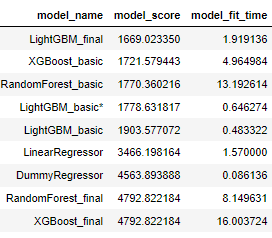

For further consideration: it seems to be reasonable to assume that even better score can be achieved for LightGBM with slightly higher values for, at least, some of the hyperparameters already tuned.

[Back to Content](#content)